**MIS 5470 - Final Project: Single-Cell RNA-Seq Analysis of an E18 Mouse Brain: Cell Type Mapping and Gene Expression Prediction - COLORS IN MOLECULAR BIOLOGY"**

**By: V. Novellus Washington**


**Introduction**

Single cell RNA sequence (scRNA-seq) is a powerful analysis tool for the levels of mature RNA (mRNA) in a single cell (Heumos et.al., 2023). First introduced by Dr. Tang and his team in 2009, who sequenced blastopores, individual cells as a result of cell division of a fertilized egg, and oocytes, a female germ line cell involved in reproduction (Tang et.al., 2009). Since its initial use, its technology has been expanded to quantify and understand biological pathways that are involved in cell reproduction, the immune system, identification of type II diabetes regulatory markers, and many more. The power that single cell analysis places in our hands as researchers is immesurable, only being limited by the lack in our imagination. 

**Goals**

The goal of this project is to predict the clusters formed by Uniform Manifold Approximation and Projection (UMAP) as well as the expression of a selected gene marker. 
Another goal for my project is for it to serve as an introduction guide to Bioinformatics for myself and beginners alike.

**Outcomes**
- Identification of Key Marker Genes
- Cluster Identification
- Machine Learning (ML) Models
- ML Evaluation Metrics

**Dataset**

For my project, I will be analysing an 18 day embryonic House Mouse (sp Mus musculus) brain sample that contains 1,000 individual cells.

barcodes.tsv - unique cell barcodes

genes.tsv - list of genes

matrix.mx - matrix of gene expression counts





**Installing all necessary packages and Importing them**



In [6]:
#1 Supress warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
#2 installing the scanpy package that will be used for single cell data analysis
!pip install scanpy
!pip install igraph
!pip install leidenalg
!pip install leidenalg
!pip install adjustText


In [2]:
#3 Importing the necessary packages
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

**Data Retrieval and Exploratory Data Analysis**


**You only need to run the file retrieval and unzipping once**

In [5]:
#4 Retreiving the file from the online database and saving the output in the specified directory. 
!mkdir -p data
!curl -L -o data/neurons_900_filtered_gene_bc_matrices.tar.gz https://cf.10xgenomics.com/samples/cell-exp/2.1.0/neurons_900/neurons_900_filtered_gene_bc_matrices.tar.gz
!tar -xzf data/neurons_900_filtered_gene_bc_matrices.tar.gz -C data
!mkdir -p write

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file data already exists.
Error occurred while processing: data.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 8759k    0   671    0     0   1019      0  2:26:41 --:--:--  2:26:41  1022
100 8759k  100 8759k    0     0  9647k      0 --:--:-- --:--:-- --:--:-- 9667k
A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file write already exists.
Error occurred while processing: write.


In [9]:
#5 Adjusting the output settings of scanpy
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [10]:
#6 Storage file for the analysis
results_file = "write/neurons_900.h5ad"

In [11]:
#7 Checking the location of the Data file
working = os.getcwd()
print(working)
print(os.listdir("data/filtered_gene_bc_matrices/mm10"))

C:\Users\vnove\OneDrive\Documents\Winter_25\PCDA\FinalProject_Washington
['barcodes.tsv', 'genes.tsv', 'matrix.mtx']


In [3]:
#8 Setting the working directory to the folder with the data file containing the gene expressions and creating variables for axis labeling
adata = sc.read_10x_mtx("data/filtered_gene_bc_matrices/mm10/",
                        var_names="gene_symbols",
                        cache=True,
                       )

adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 931 × 27998
    var: 'gene_ids'

**Data Processing**

To better understand the data that I am working with, I will be looking at the gene expression across all relevant cells (cells with high expression). By looking at the most relevant genes, we can select marker genes that we can use to label the clusters we create further down the analysis. This is an important step as it provides an overview of the data which can help guide us downstream with quality control and normalization. 

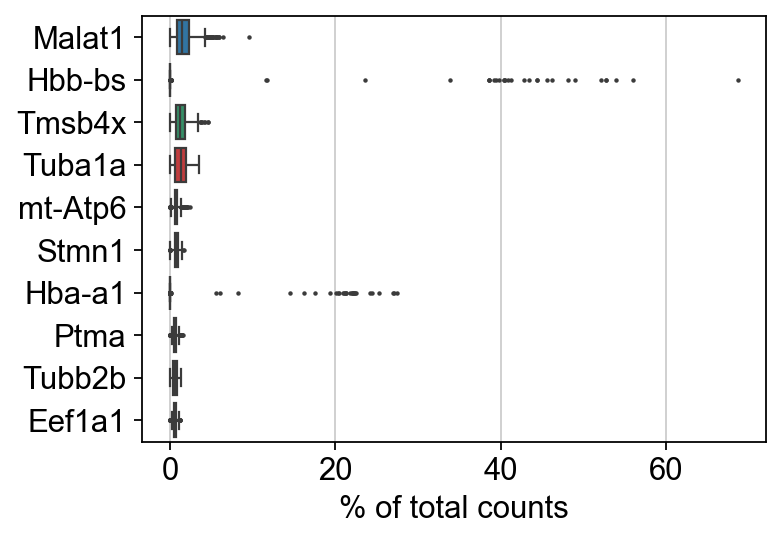

In [13]:
#9 Visualization of the top genes using the built in boxplot feature of scanpy
sc.pl.highest_expr_genes(adata, n_top = 10)

Looking at the top 10 highly expressed genes across all cells, the algorithm identified genes such as **Malat1** (involved in gene regulation, splicing and metastasis), **Hbb-bs** (involved in oxygen transport), and **Tnsv4x** (actin polymerazation regulator and involved in cell migration).

In [4]:
#10 Data filtering for cells that express less than 100 genes and genes that are expressed in less than 2 cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)

**The role of Mitochondrial Genes (mt) in Cell Expression**

An important source of information for a single cell analysis are **Mitochondrial Genes**. In addition to providing important information (Nitsch et.al., 2024), **Mitochondrial Genes** can be a source of noise that reduces the accuracy of detecting important marker genes in an analysis. The noise is the result of cells undergoing apoptosis or stress causing mtDNA to leak into the cytoplasm from the mitochondria. **Mitochondrial Genes** expression can be released into the cytoplasm when a cell is under stress or undergoing apoptosis (Ilicic et.al., 2016). Therefore, high levels of **Mitochondrial Gene Expression** can be a sign of a cell that is signaling for damage repair, elimination of pathogens, or triggering cell death under higher levels of stress. Becuase the cells are under stress, they could be low-quality markers that reduce the accuracy of the analysis.

To ensure accurate interpertable data, it is important to handle this through metric computation. By quantifying the levels of **Mitochondrial Gene Expression**, it is possible to pass the dataset through a filter to improve data accuracy. 

In [15]:
#11 Checking that the variables are genes
adata.var_names

Index(['Xkr4', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Rb1cc1', '4732440D04Rik', 'St18',
       ...
       'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb', 'Vamp7', 'Tmlhe', 'AC168977.1',
       'PISD', 'DHRSX', 'CAAA01147332.1'],
      dtype='object', length=14836)

In [5]:
#12 Creating "mt" as a new variable that contains all identified mitochondrial genes ("MT-")
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

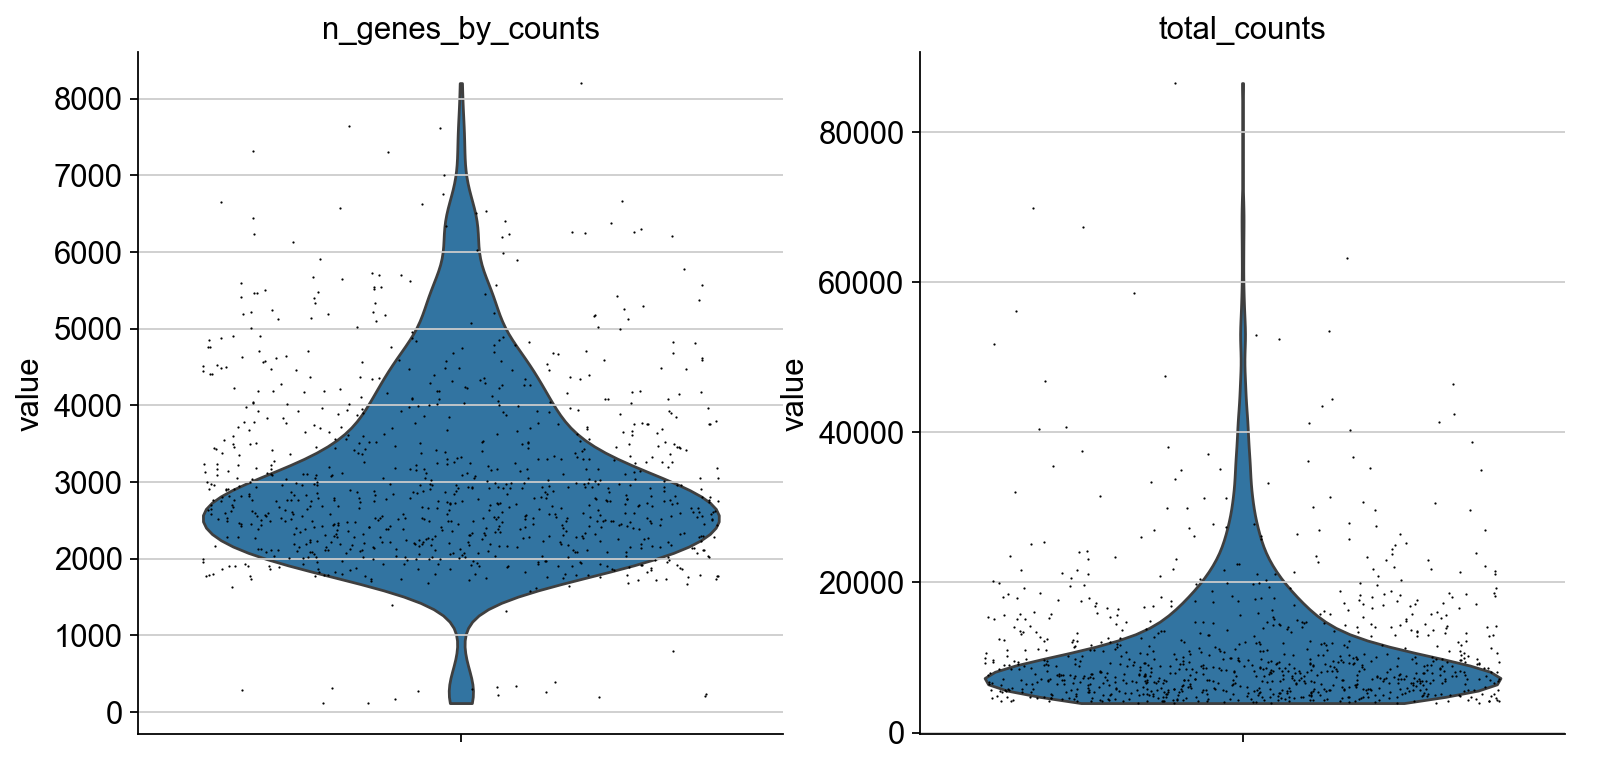

In [17]:
#13 Visualizing the mitochondrial gene expressions to understand whether a cell is under stress
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts"], jitter=0.4, multi_panel=True,)

The first graph on the left (**n_genes_by_count**), shows the diversity of gene expression. We can observe that most genes are expressed between 2,00 and 6,000, as seen by the symmetrical distribution between 2,000 and 6,000 genes. There are outliers present in the data set that can be seen by the upper extremeties of the graph. However, the grpah on the right (**total_counts graph**), quantifys RNA synthesis, is skewered towards the right, which could be due to a moderate total unique genes expressed. It is also possible for it to indicate a high cell activity.  

In [6]:
#14 Filtering out genes with low counts
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:698: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


Axes: Axes(0.146628,0.15;0.568915x0.73)
8 [-0.54083919 -0.07601726]
11 [ 0.57892735 -0.81616639]


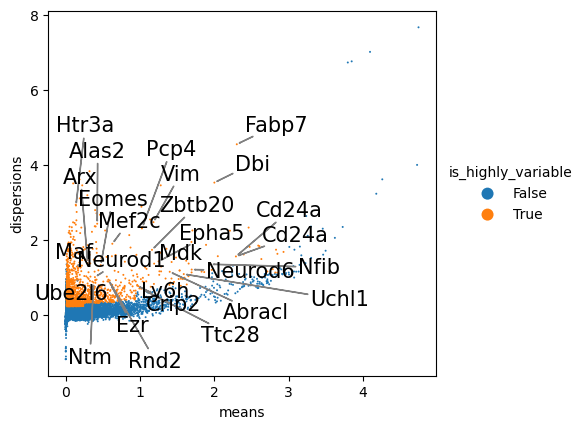

In [7]:
#15 Identifying highly varaible genes based on their expression of 
from adjustText import adjust_text

# Normalize and log1p
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Filter out genes with infinite or NaN mean values
finite_genes = np.isfinite(np.array(adata.X.mean(axis=0))).flatten()
adata = adata[:, finite_genes]  

# NApplying the highly variable genes filter
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

with plt.rc_context({"figure.figsize": (5, 5)}):
    x = "means"
    y = "dispersions"
    color = "is_highly_variable"
    adata.var["is_highly_variable"] = (
        adata.var["highly_variable"].astype(bool).astype(str)
    )
    ax = sc.pl.scatter(adata, x=x, y=y, color=color, show=False)
    print("Axes:", ax)
    ax.set_title("")
    ax.get_legend().set_title(color)

    
    # Select genes to be labeled
    texts = []
    genes = [
        "Dbi", "Vim", "Fabp7",
    "Uchl1", "Ly6h", "Ntm",
    "Abracl", "Neurod6", "Cd24a",
    "Epha5", "Ttc28", "Cd24a",
    "Rnd2", "Pcp4", "Nfib",
    "Eomes", "Mdk", "Ezr",
    "Mef2c", "Arx", "Maf",
    "Alas2", "Ube2l6", "Htr3a",
    "Zbtb20", "Crip2", "Neurod1"
    ]
    for gene in genes:
        # Position of object to be marked
        x_loc = adata.var.at[gene, x]
        y_loc = adata.var.at[gene, y]
        # Text color
        color_point = "k"
        texts.append(ax.text(x_loc, y_loc, gene, color=color_point, fontsize=15))

    # Label selected genes on the plot
    _ = adjust_text(
        texts,
        expand=(1.2, 1.2),
        arrowprops=dict(color="gray", lw=1),
        ax=ax,
    )


The scatter plot visualizes gene variability across cells. Genes colored in orange are flagged as highly variable, they are functionally important in distinguising cell types or stages and can be used as markers. The identified orange genes will be used for downstream analyses like clustering and dimensionality reduction.

In [20]:
#16 Save a copy of the unprocessed data as nackup
adata.raw = adata.copy()

In [8]:
#17 Preping the data for PCA and clustering using linear regression to eliminate noise
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

C:\Users\vnove\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


In [9]:
#18 Dimensionality reductionusing PCA
sc.tl.pca(adata, svd_solver="arpack")

In [10]:
#19 Seeing the top 10 genes of the dataset with a mean count over 0.1
adata.var.head(10)[adata.var.head(10)["mean_counts"] > 0.100]

gene_ids  n_cells     mt  n_cells_by_counts  mean_counts  \
Ncoa2   ENSMUSG00000005886      117  False                117     0.149837   
Eya1    ENSMUSG00000025932       80  False                 80     0.102063   
Kcnb2   ENSMUSG00000092083      154  False                154     0.212812   
Gdap1   ENSMUSG00000025777      315  False                315     0.530945   
Mcm3    ENSMUSG00000041859      129  False                129     0.312704   
B3gat2  ENSMUSG00000026156      120  False                120     0.195440   
Adgrb3  ENSMUSG00000033569      121  False                121     0.176982   
Prim2   ENSMUSG00000026134      186  False                186     0.282302   
Mitd1   ENSMUSG00000026088      163  False                163     0.235613   
Rnf149  ENSMUSG00000048234      260  False                260     0.397394   

        pct_dropout_by_counts  total_counts  highly_variable     means  \
Ncoa2               87.296417         138.0             True  0.081802   
Eya1                91.313789          94.0             True  0.052522   
Kcnb2               83.279045         196.0             True  0.085817   
Gdap1               65.798046         489.0             True  0.247215   
Mcm3                85.993485         288.0             True  0.084425   
B3gat2              86.970684         180.0             True  0.042227   
Adgrb3              86.862106         163.0             True  0.055370   
Prim2               79.804560         260.0             True  0.093818   
Mitd1               82.301846         217.0             True  0.093810   
Rnf149              71.769815         366.0             True  0.149873   

        dispersions  dispersions_norm is_highly_variable          mean  \
Ncoa2      0.287759          0.731897               True  1.387779e-17   
Eya1       0.310719          0.820195               True  7.806256e-18   
Kcnb2      0.254149          0.602644               True  2.498002e-17   
Gdap1      0.341621          0.588785               True  5.412337e-17   
Mcm3       0.543182          1.714175               True  2.220446e-17   
B3gat2     0.337162          0.921887               True  9.714451e-18   
Adgrb3     0.322044          0.863746               True  1.561251e-17   
Prim2      0.266485          0.650083               True  1.942890e-17   
Mitd1      0.245568          0.569644               True  1.144917e-17   
Rnf149     0.247580          0.577380               True  2.636780e-17   

             std  
Ncoa2   0.203347  
Eya1    0.165342  
Kcnb2   0.208588  
Gdap1   0.347857  
Mcm3    0.213982  
B3gat2  0.146395  
Adgrb3  0.166742  
Prim2   0.218102  
Mitd1   0.217728  
Rnf149  0.273219

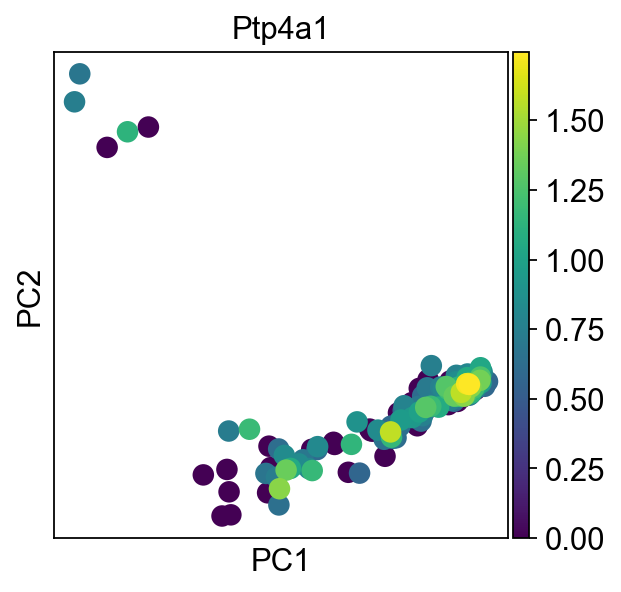

In [24]:
#20 Graphing a gene to check it works
sc.pl.pca(adata, color="Ptp4a1")

**Ptp4a1 Gene Expression Analysis**

Observing the graph above, there is expression variance for the gene **Ptp4a1**. With many of the expression being low, however a single high expression can be observed by the yellow dot. This could point towards the possibility that **Ptp4a1** is specific to certain cells or a certain function. 

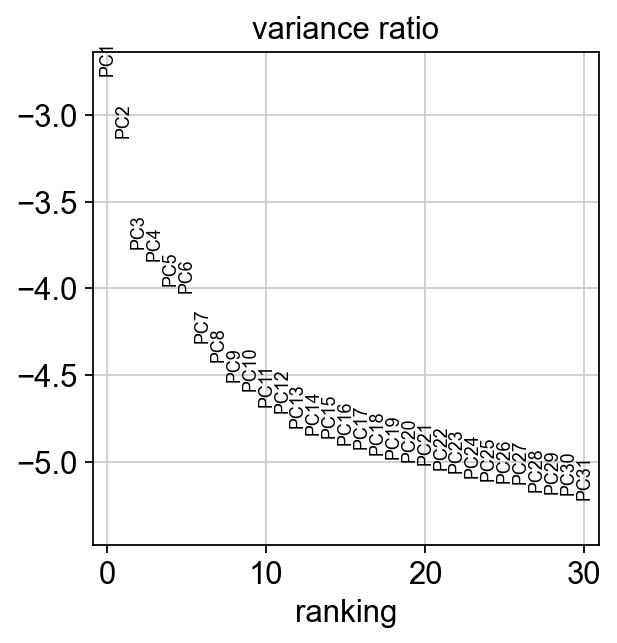

In [25]:
#21 Selecting how many Principal Components to use to help explain differences between cells
sc.pl.pca_variance_ratio(adata, log=True)

Based on the variance graph above, I will be using 7 principal compenents

In [26]:
#22 Saving my results
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 320 × 1687
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'is_highly_variable', 'mean', 'std'
    uns: 'log1p', 'hvg', 'is_highly_variable_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

**Computing Neighborhood Graph**

To help understand the relationship between cells, we will compute neighborhood graphs to cluster cells together based on similar expressed genes. The cells will be grouped using a leiden algorithm, and with this data we can better understand different cell types, developmental states or biological responses.

In [11]:
#23 Calculating neighboors
sc.pp.neighbors(adata, n_neighbors=7, n_pcs=40, knn=True)  

In [12]:
#24 Creating a UMAP with clusters based on cells with neighboring gene expressions 
sc.tl.leiden(adata)
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')

C:\Users\vnove\AppData\Local\Temp\ipykernel_31780\648249755.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


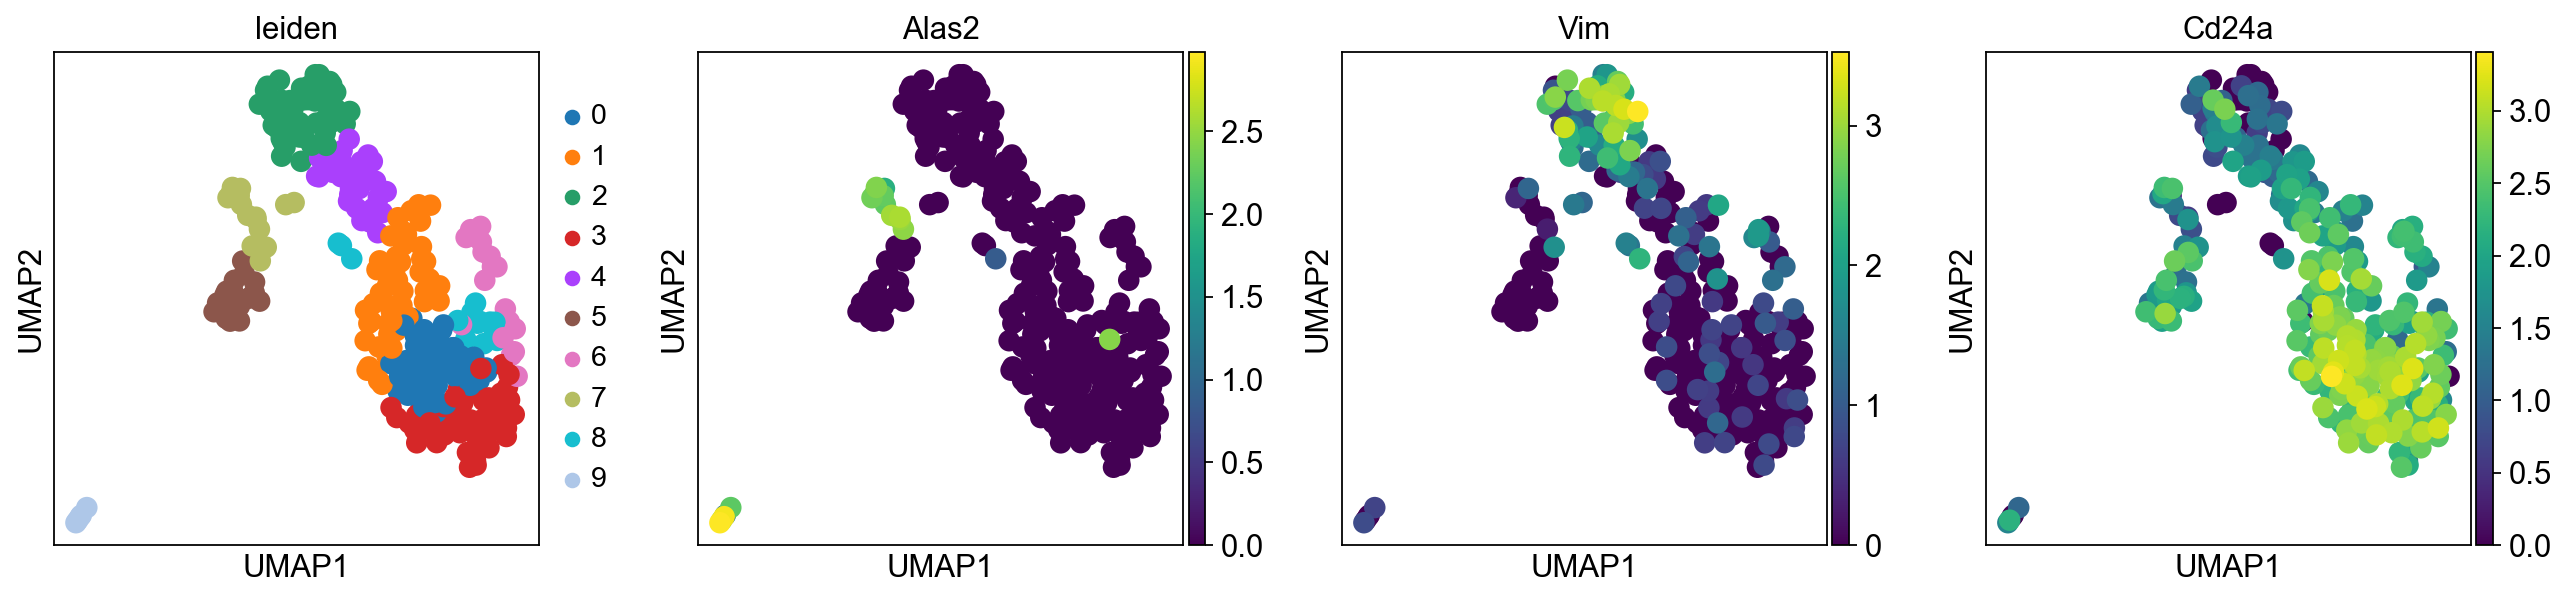

In [30]:
#25 Plotting
sc.pl.umap(adata, color=["leiden", "Alas2", "Vim", "Cd24a"]) 

Looking at the genes selected above, we can see that **Alas2**, a gene involved in the synthesis of the oxygen carrying molecule in blood known as Heme, and **Cd24a**, a gene involved in gene regulation/immune response, show similar expression patterns. This co-expression may suggest a role in coordinated developmental processes or cell types within the tissue.

Comapred to the previous two, **Vim** is highly expressed in certain areas but maintains lower expresssion through out the rest of the cvluster. This alludes to the possibility of **Vim** being a gene that is expressed in a specific cell type.

**Finding Marker Genes**

C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\Users\vnove\anaconda3\Lib\site-packages\scanpy\tools\_rank_gen

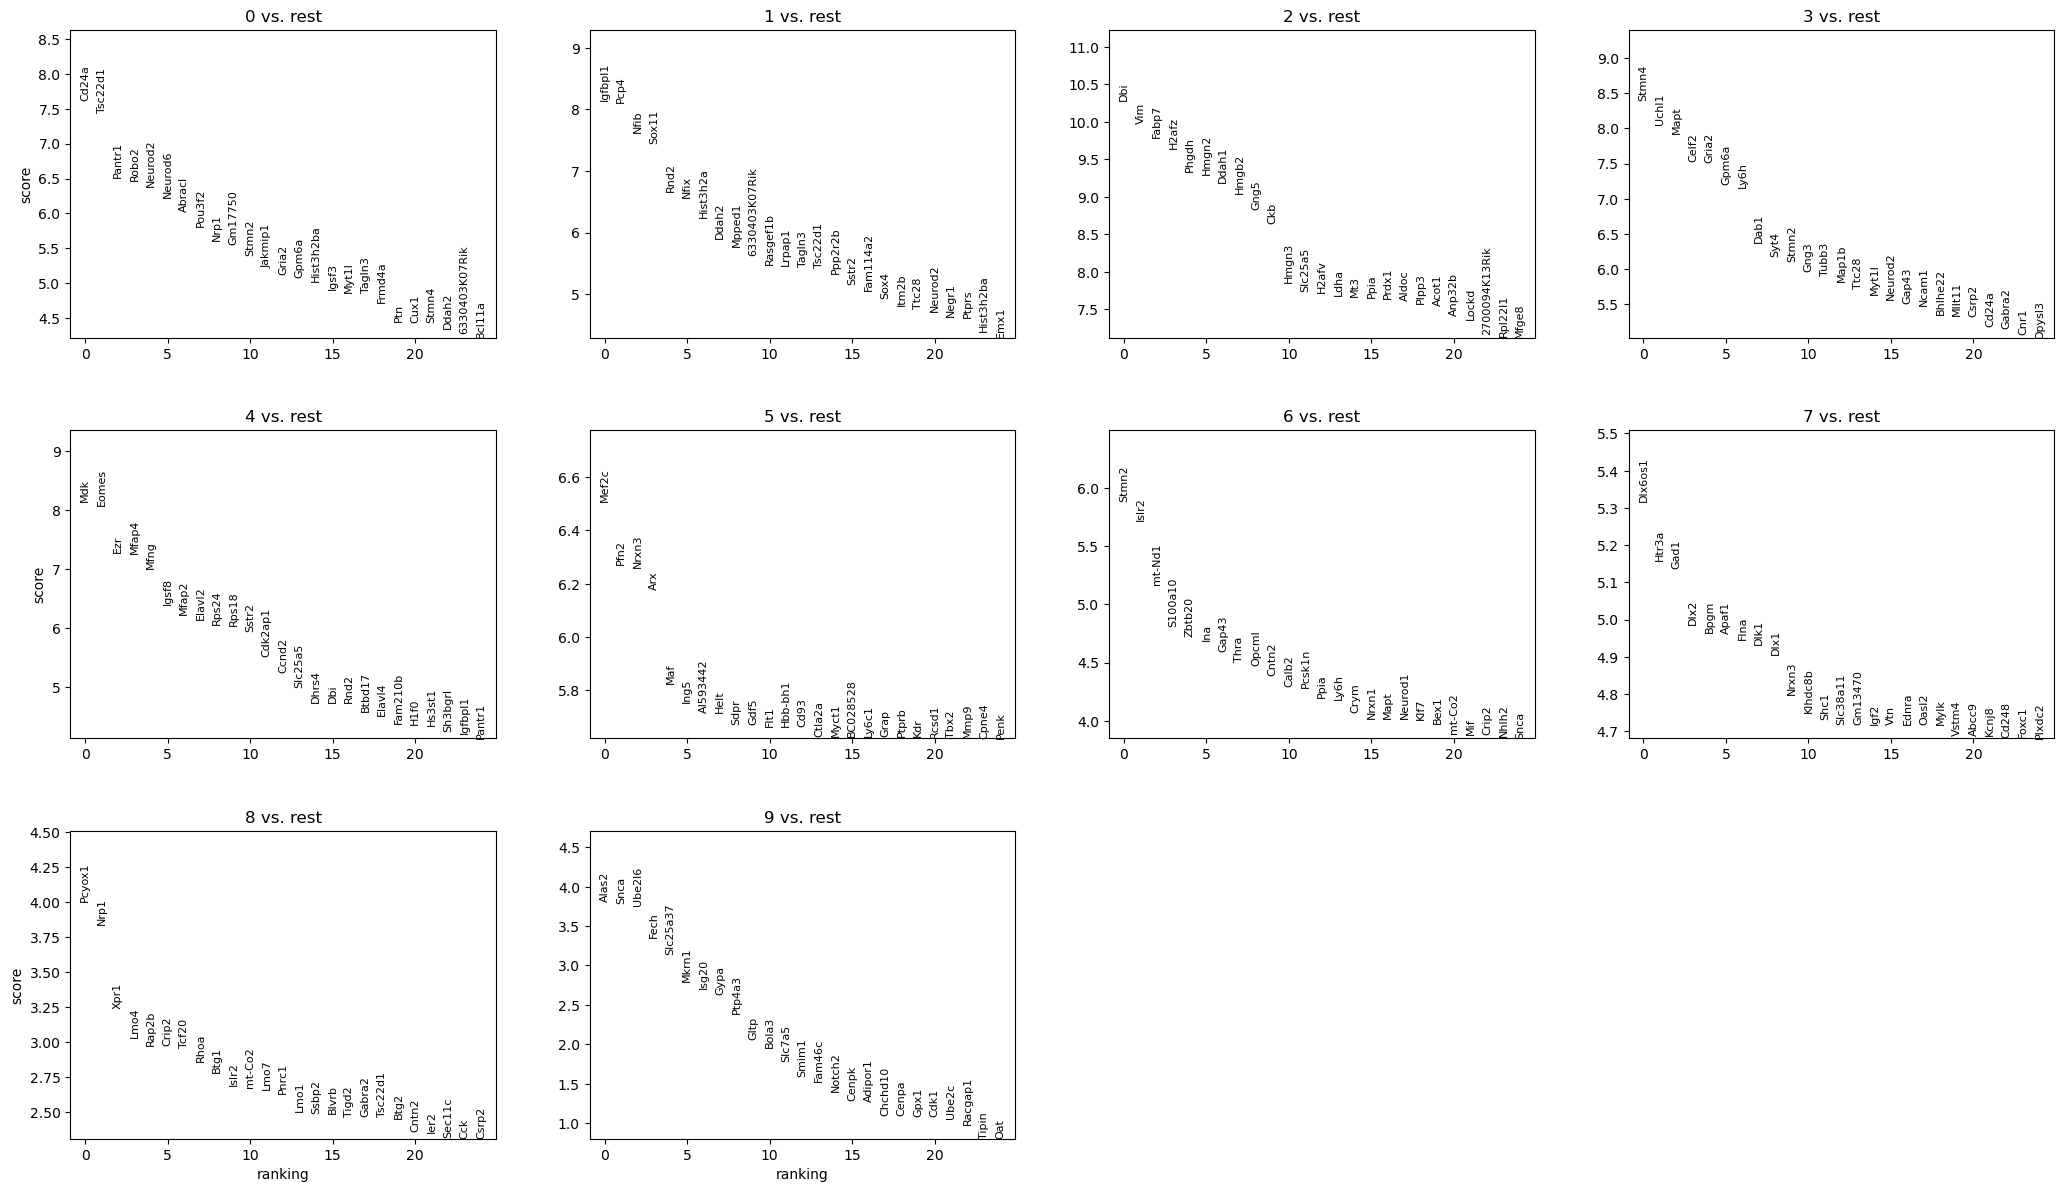

In [15]:
#26 Using the Wilcoxon test to identify classical marker genes that are consistently hihgly expressed
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
#27 Saving information
os.makedirs("write", exist_ok=True)
adata.write(results_file)

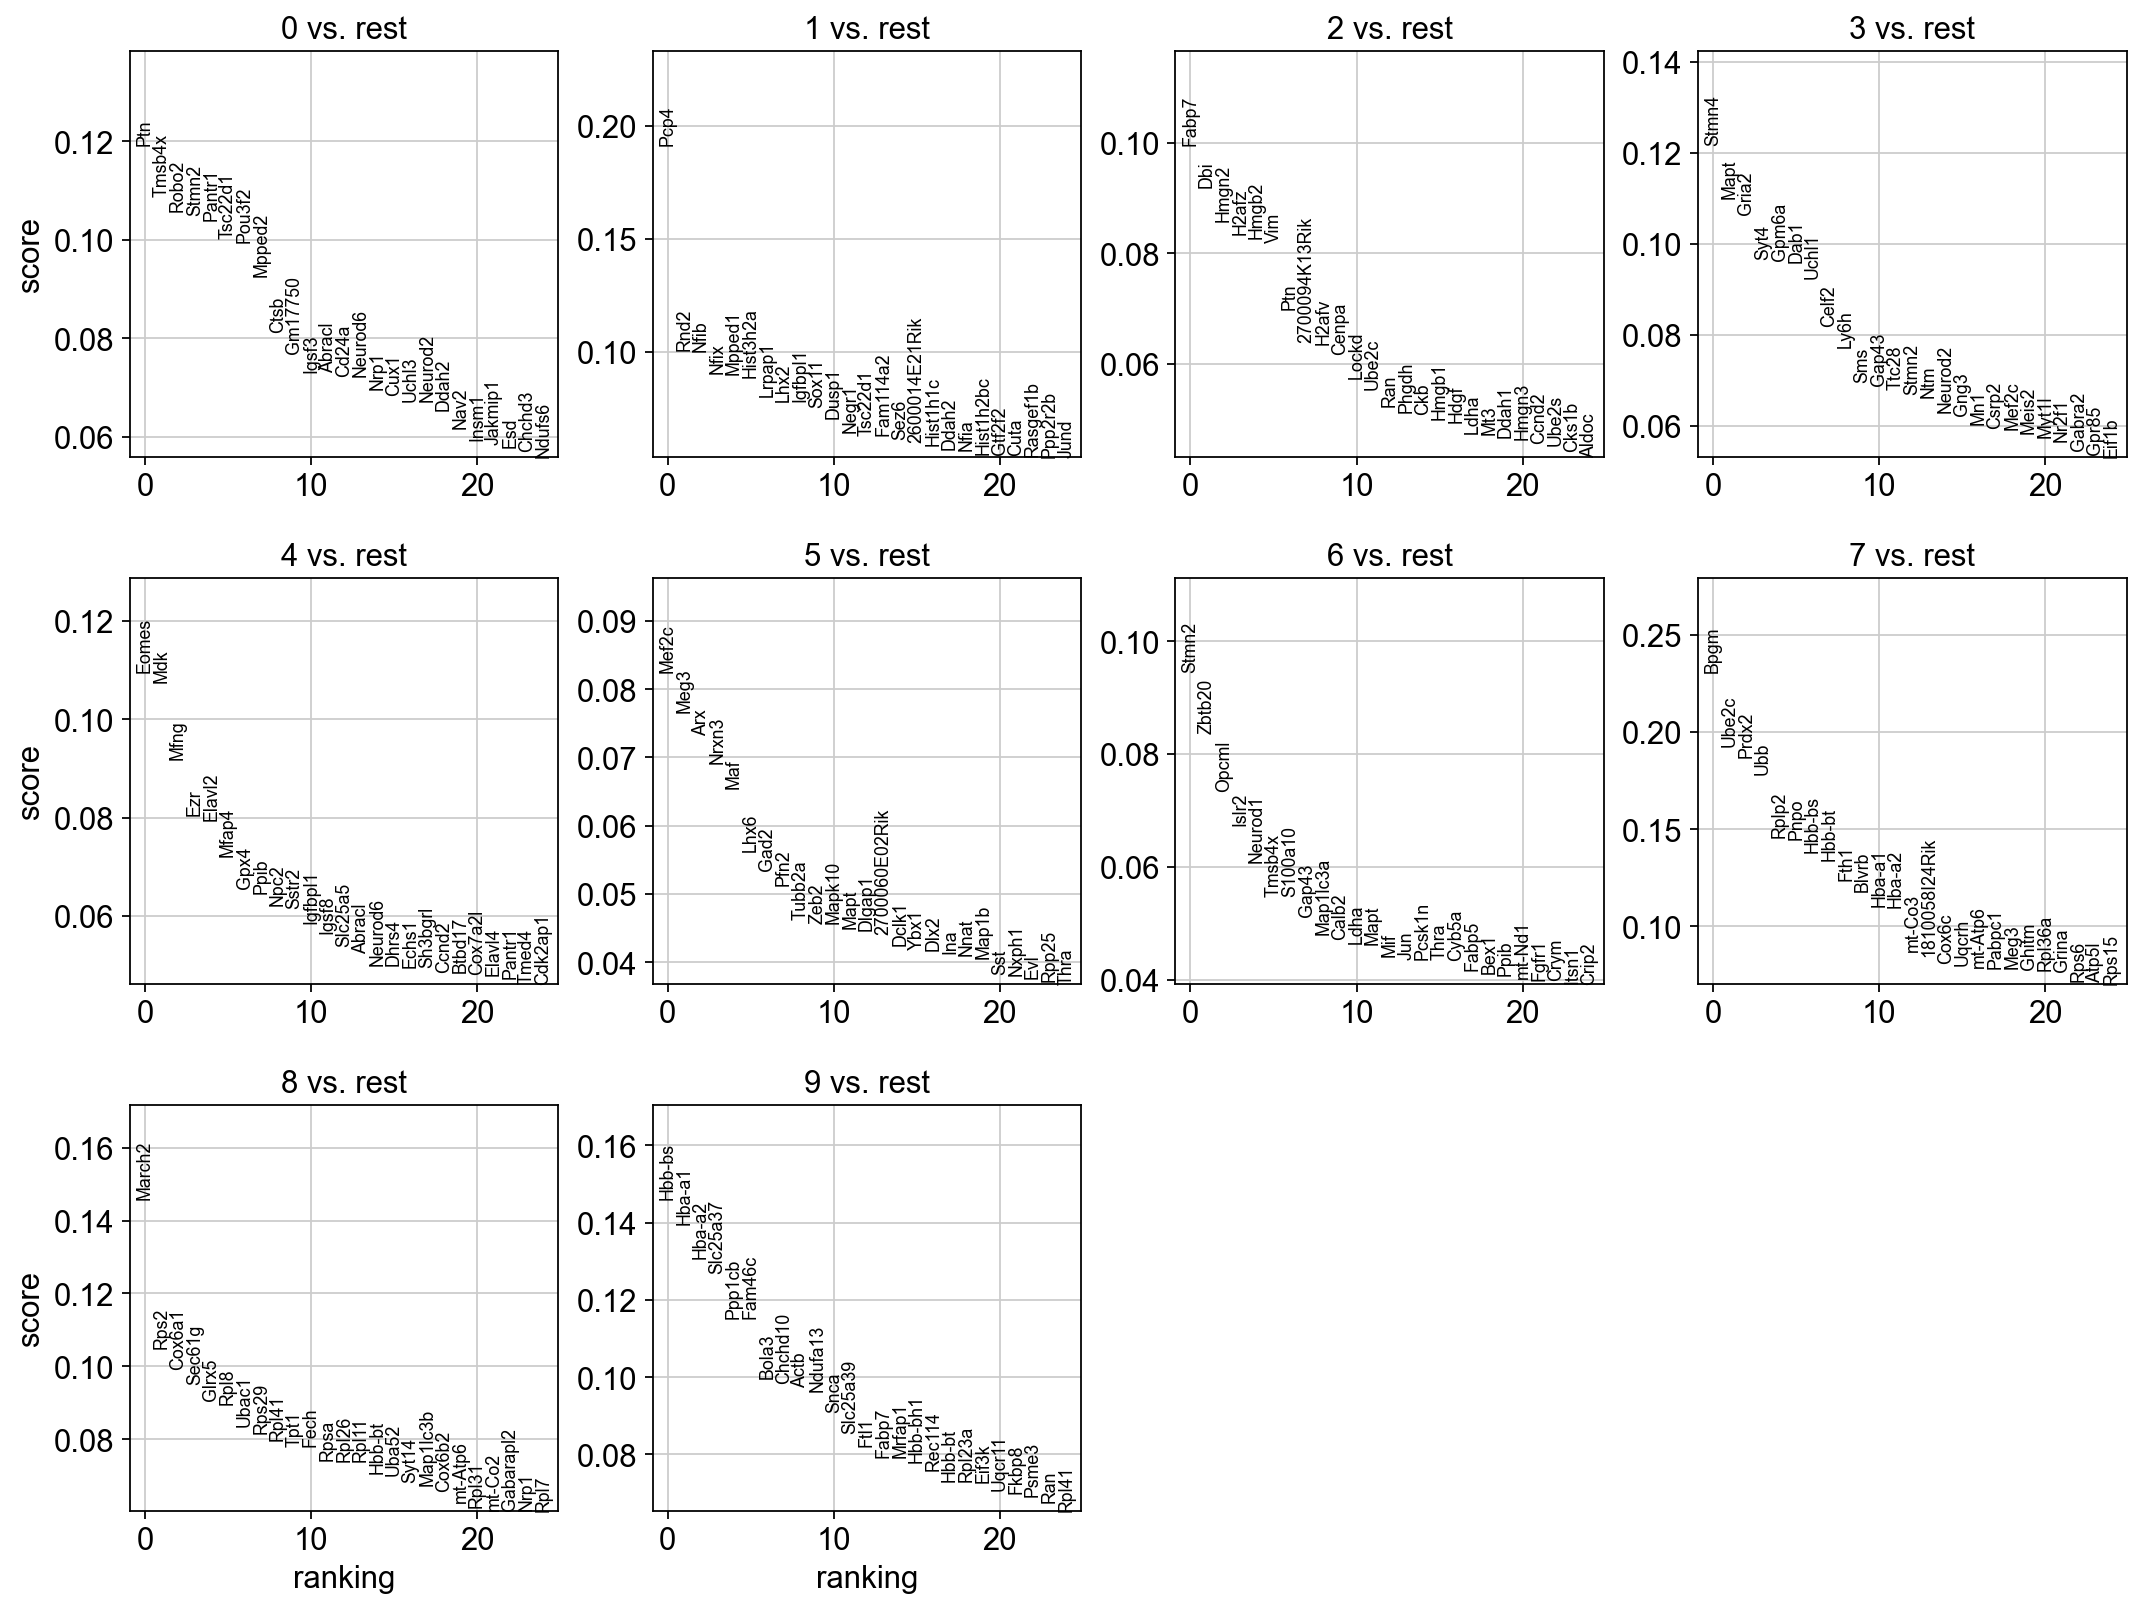

In [33]:
#28 Identifying marker genes to be used for predictive modeling using a logistical regression function
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
#29 Based on the wilcoxon test, we have selected these genes as markers
marker_genes = [
    "Mkrn1", "Fnbp1l", "Racgap1",
    "Crym", "Zdhhc18", "Traf2",
    "Osbpl9", "Neurod6", "Cd24a",
    "Tox2", "Tubb3", "Dynll1",
    "Vim", "Dbi", "Cox7a2",
    "Mxi1", "Lockd", "Ezr",
    "Shmt2", "Lhx6", "Tubb2a",
    "Alas2", "Ube2l6", "Htr3a",
    "Cenpa", "Crip2", "Lhx6"
]


In [35]:
#30 Reloading the saved files into adata
adata = sc.read(results_file)

In [14]:
#31 Checking the file in a tabular format
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

KeyError: 'rank_genes_groups'

In [13]:
#32 Ranking genes based on their cluster organization and pvalue
result = adata.uns["rank_genes_groups"]
groups=result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

KeyError: 'rank_genes_groups'

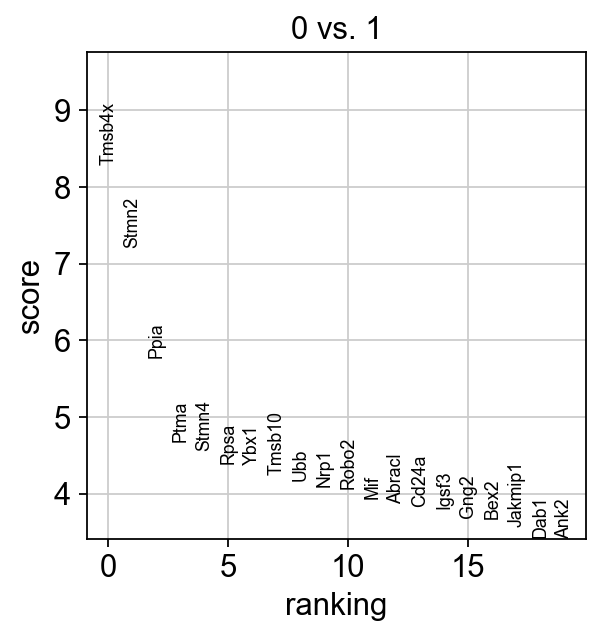

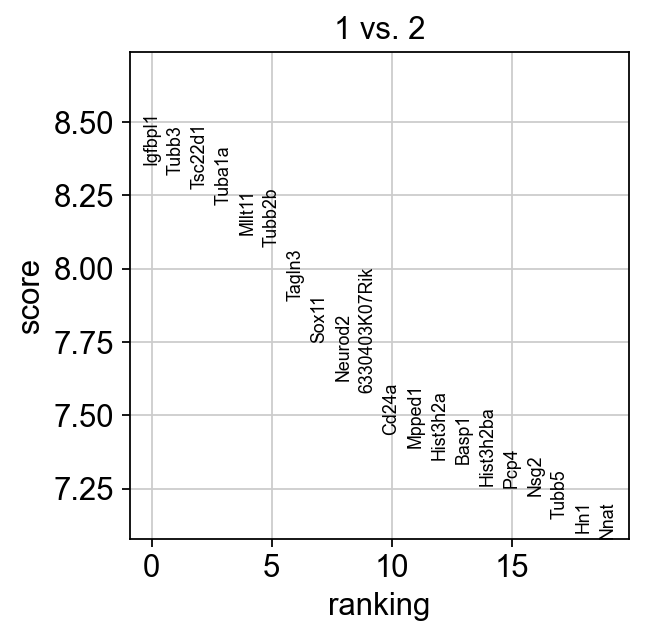

In [38]:
#33 Ranking the top 20 prominent genes using the wilcoxon method in group 0
sc.tl.rank_genes_groups(adata, "leiden", groups=[0], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

sc.tl.rank_genes_groups(adata, "leiden", groups=[1], reference="2", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["1"], n_genes=20)

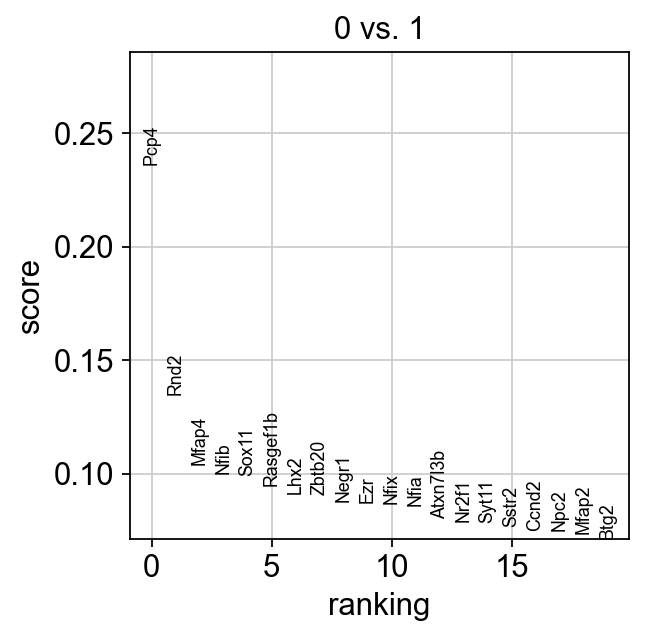

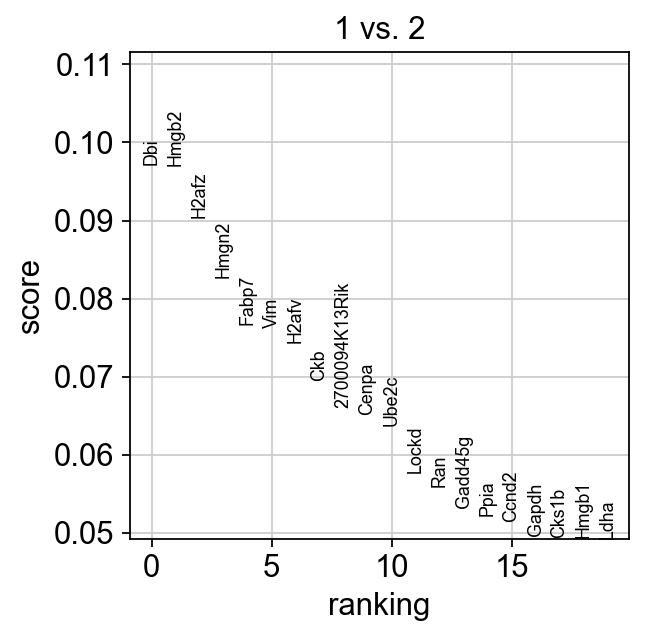

In [39]:
#34 Ranking the top 20 prominent genes using a log regression 
sc.tl.rank_genes_groups(adata, "leiden", groups=[0], reference="1", method="logreg")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

sc.tl.rank_genes_groups(adata, "leiden", groups=[1], reference="2", method="logreg")
sc.pl.rank_genes_groups(adata, groups=["1"], n_genes=20)

In [40]:
#35 Reloading the results_file into adata
adata = sc.read(results_file)

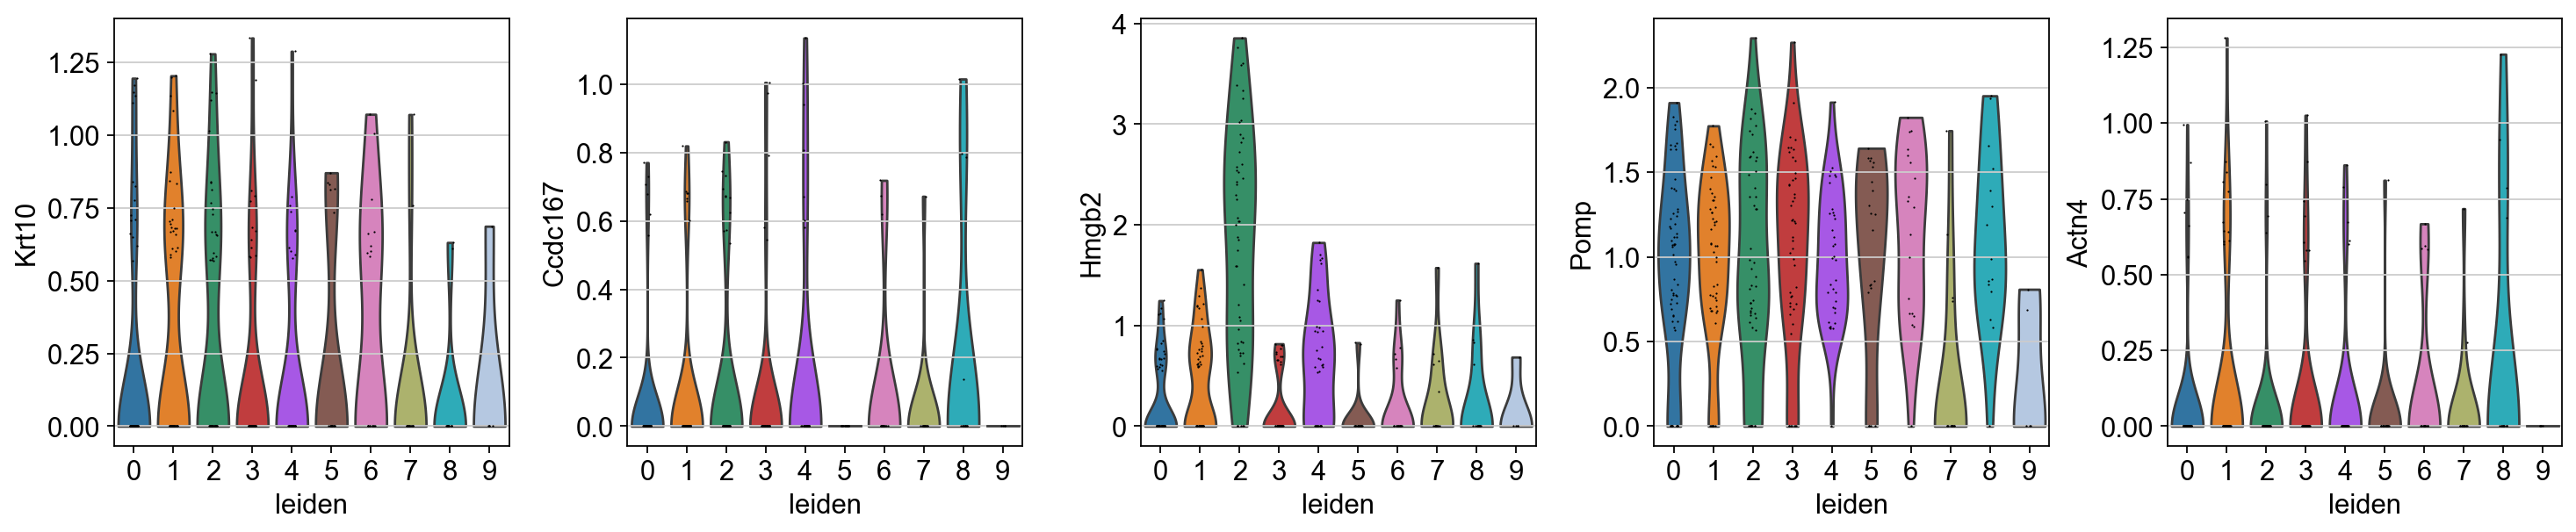

In [41]:
#36 Visualizing gene marker expression across the different clusters
sc.pl.violin(adata, ["Krt10", "Ccdc167", "Hmgb2", "Pomp", "Actn4"], groupby="leiden")

**Marker Genes Violin Plot**

The violin plots show the expression levels of five genes (**Krt10, Cdca1g7, Hmgb2, Pomp, and Actr1**) across Leiden defined clusters (0-9). Notably, **Hmgb2** and **Krt10** have  distinct expression patterns in specific clusters pointing to their potential as markers for cell type specific markers and cluster identification. While **Pomp** and **Actr1** are more broadly expressed, indicating a role in multiple cell populations. 

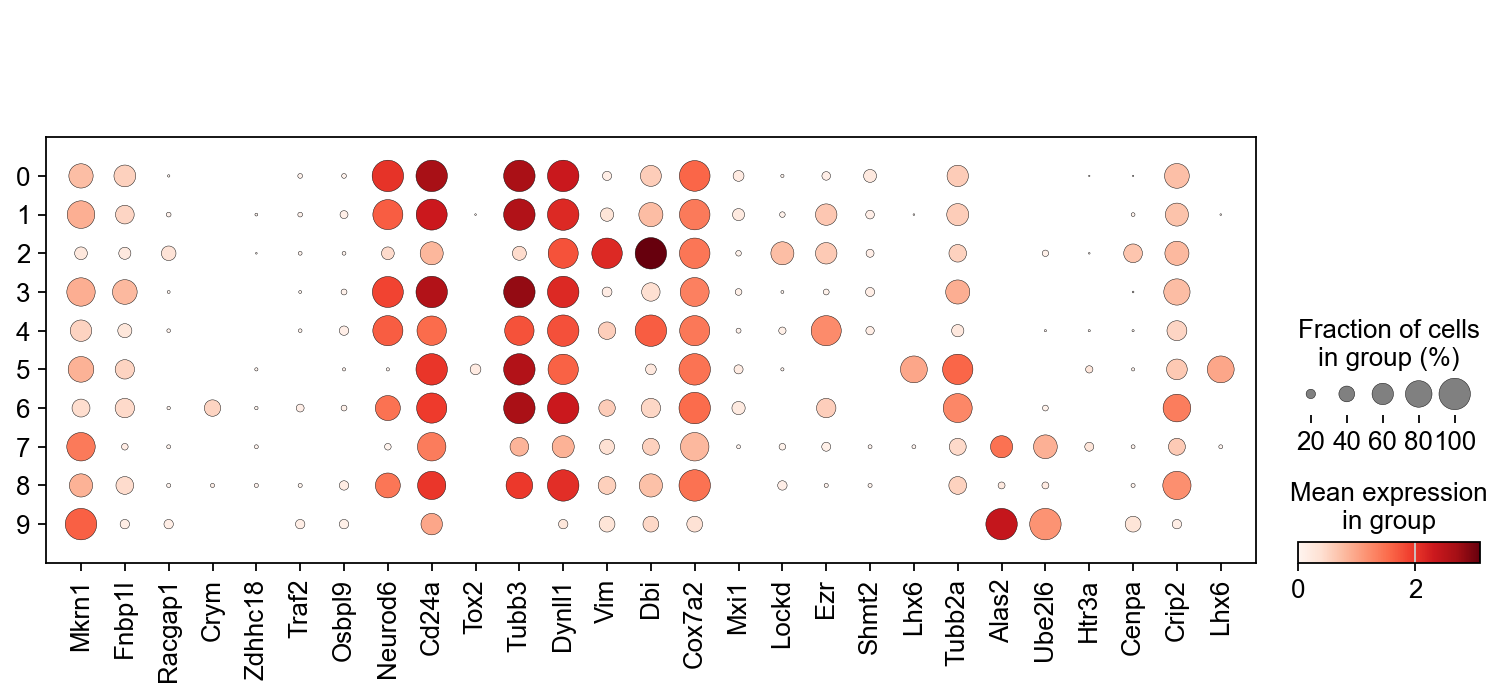

In [42]:
#37 Visualizing the selected marker gene expressions across the different clusters
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

**Dot Plot Analysis**

Using this dot plot combined with a color gradient to visualize the mean gene expression level we identify a few more marker genes for cell type specification and cluster identification. **Tubb3** (Clusters 0, 1, 3, 4 ,5), **Vim** (Clusters 2, 6, 8), and **Tubb2a** (Cluster 5). While **Cd24a** has a high mean expression in all clusters except cluster 8. This points to it being an essential for basic cell types and have no use as a differentiator. 

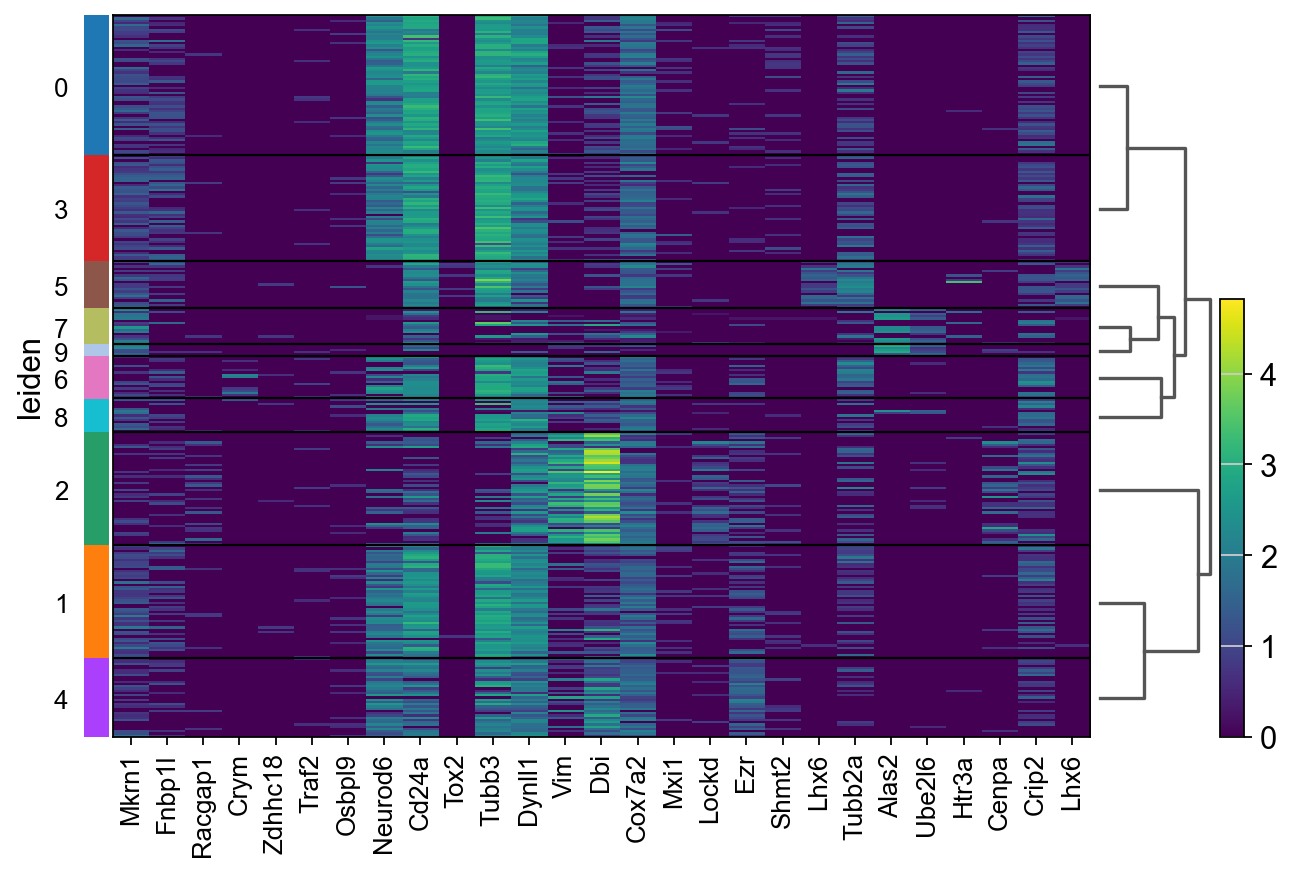

In [38]:
#38 Visualizing the selected marker genes using a heatmap
ax = sc.pl.heatmap(
    adata, marker_genes, groupby="leiden", cmap="viridis", dendrogram=True
)

**Gene expression Heatmap**

To get a better idea of gene expression and to select good cluster markers, I have used a heatmap that is divided into rows by cluster. On the right of the map, the trees indidcate co-expression amongst the genes. Understanding co-expression is important because it tells us if the genes belong to the same pathway and they are joint markers for cell type or state.

In [43]:
#39 Based on the exploratory data analysis above, I have selected these as the cluster names based on gene markers
new_cluster_names = [
    "Early Neurons Precursos", #Tubb3 and Dcx for cluster 0
    "Intermediate Neurons", #Fabp7, Tuba1a/1b for cluster 1
    "Neuron Maturation", #Dynll1 and Cox7a2 for cluster 2
    "Cell Migration", #Actn4, Actr1 for cluster 3
    "Mesenchymal stem-like", #Low marker gene expression
    "Dividing Neurons", #Tubb2a, Tubb2b for cluster 5
    "Precusor Cells", #Vim, Tuba2b, Dynll for cluster 6
    "Radial Glia", #Vimentin and Fabp7 for cluster 7
    "Housekeeping", #Cd24a for clsuter 8
    "Cycling Precursors" #Tubb3, Vim, Dynll1 for custer 9
]
adata.rename_categories("leiden", new_cluster_names)


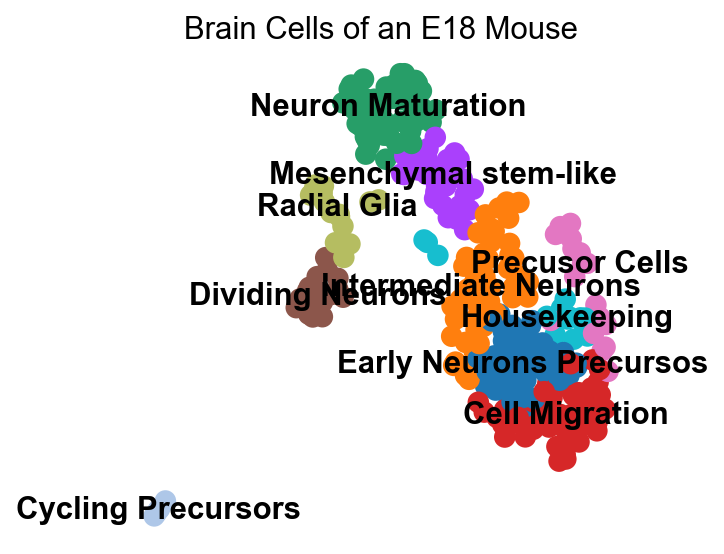

In [44]:
#40 Renaming the clusters based on the selected marker gene expressions
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="Brain Cells of an E18 Mouse", frameon=False,
)

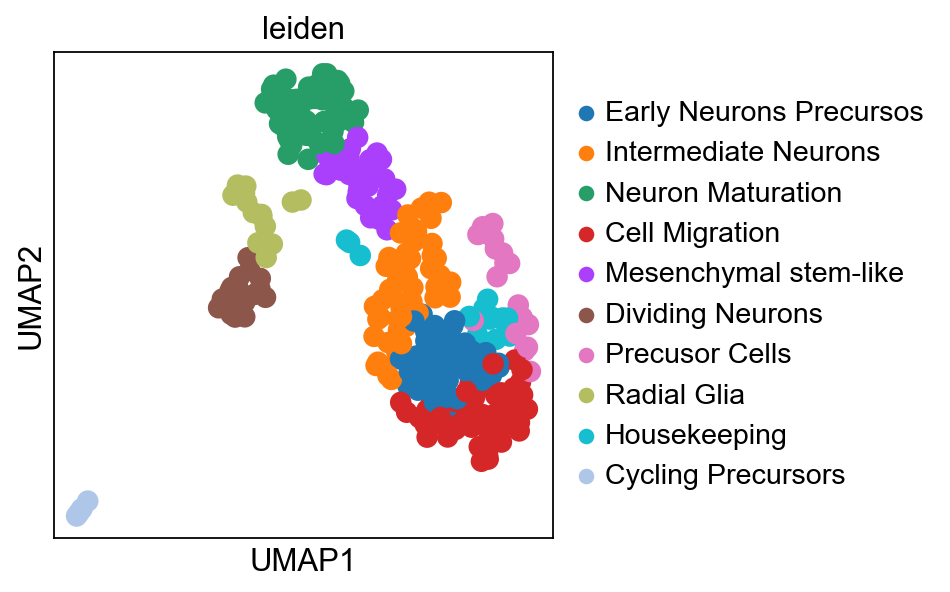

In [45]:
#41 Side legend of graph above
sc.pl.umap(adata, color=["leiden"])

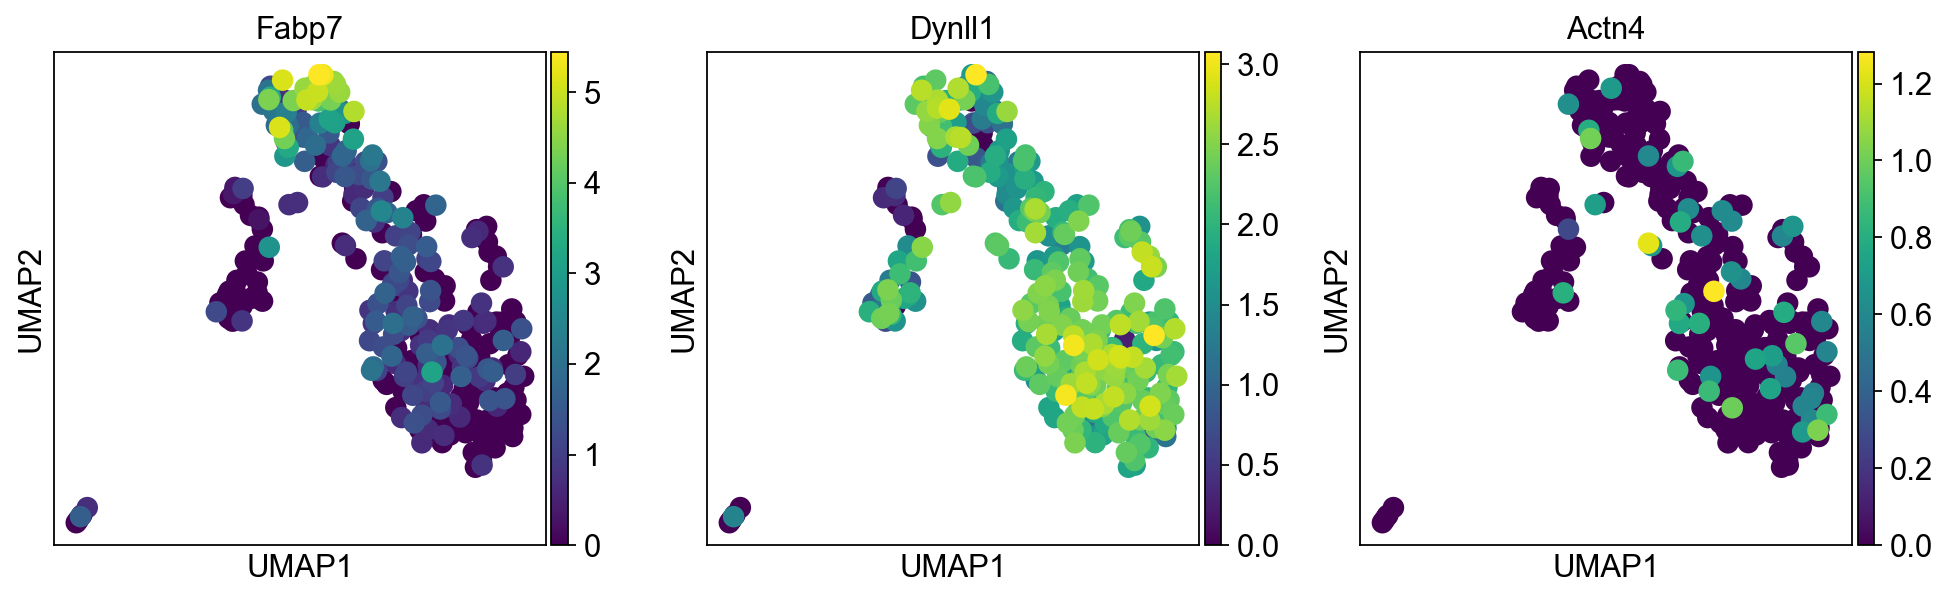

In [46]:
#42 Plotting different genes to cross reference with the identified clusters
sc.pl.umap(adata, color=["Fabp7", "Dynll1", "Actn4"]) 

In [47]:
#43 Looking at the structure of the dataset
adata.obs.head()

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACGGGAGCCACGTC-1     2284               2284        5717.0              0.0   
AAACGGGAGCGAGAAA-1     2105               2105        5189.0              0.0   
AAAGTAGGTACAGACG-1     2110               2110        6417.0              0.0   
AAAGTAGGTTGGACCC-1     2492               2492        7341.0              0.0   
AAATGCCCAGATTGCT-1     2021               2020        4678.0              0.0   

                    pct_counts_mt                   leiden  
AAACGGGAGCCACGTC-1            0.0     Intermediate Neurons  
AAACGGGAGCGAGAAA-1            0.0     Intermediate Neurons  
AAAGTAGGTACAGACG-1            0.0  Early Neurons Precursos  
AAAGTAGGTTGGACCC-1            0.0  Early Neurons Precursos  
AAATGCCCAGATTGCT-1            0.0     Intermediate Neurons

**Selecting marker gene for predicting using logistical regression as a filter method**

In [48]:
#44 Checking columns
print(adata.obs.columns.tolist())
print(len(adata.var_names))
print(adata.var_names[:30])

['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden']
1687
Index(['Ncoa2', 'Eya1', 'Kcnb2', 'Gdap1', 'Mcm3', 'B3gat2', 'Adgrb3', 'Prim2',
       'Mitd1', 'Rnf149', 'Gm29260', 'Pantr1', '1500015O10Rik', 'Tpp2',
       'Col5a2', 'Slc40a1', 'Slc39a10', 'Tmeff2', 'Sdpr', 'Gtf3c3', 'Pgap1',
       'Ankrd44', 'Mars2', 'Satb2', 'Spats2l', 'Raph1', 'Nrp2', 'Gm20342',
       'Klf7', 'Mettl21a'],
      dtype='object')


**Building a Decision Tree to predict Neurog2 Expression**

I will be predicting the expression levels of **Neurog2**, I have selected this gene because of its potential as a gene marker for Neuron maturation cells. I have selected this gene based on the logistical regression. **Neurog2** is a highly valuable gene marker for cell neuron maturation cells, which help with differentiating neurons during development. Being able to predict **Neurog2** expression could improve our understanding of baseline transcriptional activity and provide a foundation for distinguishing between true biological signals and general cell maintenance processes.

In [4]:
#45 Importing sklearn package to build the decision tree
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

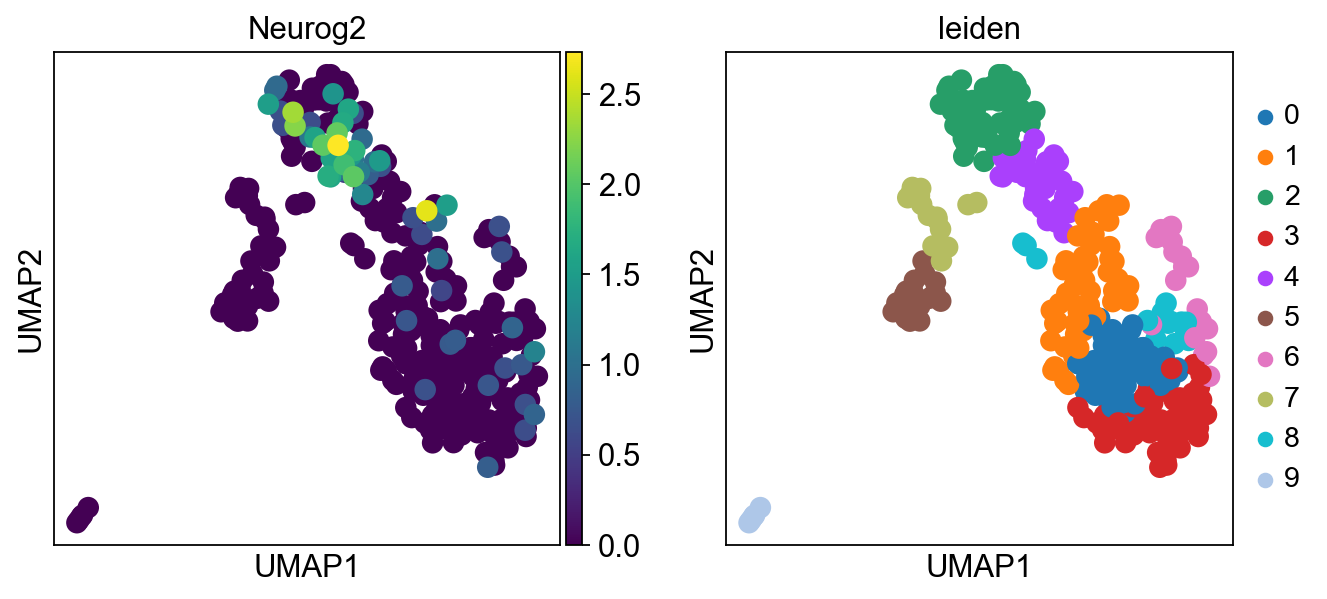

In [27]:
sc.pl.umap(adata, color=["Neurog2", "leiden"]) 

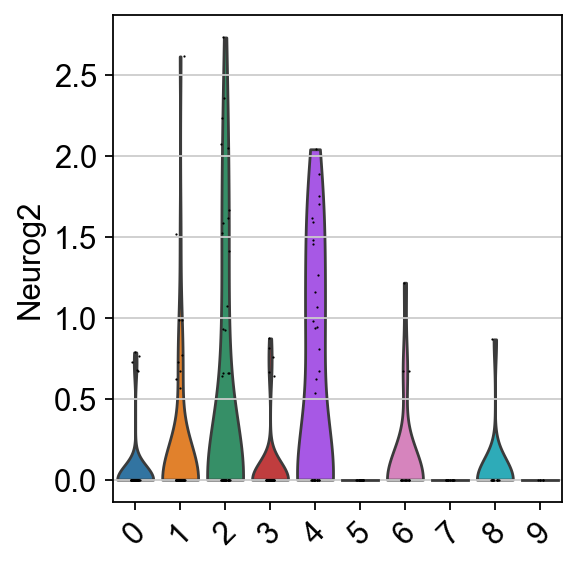

In [28]:
#46 Visualizing the selected gene marker expression 
sc.pl.violin(adata, ["Neurog2"], groupby="leiden", rotation=45)

In [51]:
#47 Creating a dataframe that has total_counts as a classifiying variable based on gene expression
df = pd.DataFrame({
    "Neurog2_expr": adata[:, "Neurog2"].X.toarray().flatten(), 
    "UMAP1": adata.obsm["X_umap"][:, 0],  
    "UMAP2":adata.obsm["X_umap"][:, 1], 
    "total_counts": adata.obs["total_counts"] 
})

In [52]:
print(df.head(5))

                    Neurog2_expr      UMAP1     UMAP2  total_counts
AAACGGGAGCCACGTC-1     -0.414877   7.774678  6.419210        5717.0
AAACGGGAGCGAGAAA-1     -0.416134   8.718209  9.625616        5189.0
AAAGTAGGTACAGACG-1     -0.413209   9.681655  5.366924        6417.0
AAAGTAGGTTGGACCC-1     -0.411008  11.741842  6.239690        7341.0
AAATGCCCAGATTGCT-1     -0.417352   7.639208  7.744948        4678.0


In [53]:
#48 Converting the eome expression into a binary format
df["Neurog2_high"] = (df["Neurog2_expr"] > df["Neurog2_expr"].median()).astype(int)

In [54]:
#49 Selecting predictors and target
y = df["Neurog2_high"]
x = df[["UMAP1", "UMAP2", "total_counts"]]

In [55]:
#Splitting the data
from sklearn.model_selection import train_test_split

#Setting seed
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [56]:
#51 Training the decision tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(x_train, y_train),

(DecisionTreeClassifier(max_depth=3, random_state=42),)

In [57]:
#52 Evaluating Model
y_pred = clf.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92        36
           1       1.00      0.79      0.88        28

    accuracy                           0.91        64
   macro avg       0.93      0.89      0.90        64
weighted avg       0.92      0.91      0.90        64



The decision tree model achieved a strong overall accuracy of **91%**, with balanced performance across both classes. Interestingly, it had a strong performance predicting class 1 (high **Neurog2** expression), with a **precision of 0.93**, showing a high confidence when predicting active cells.

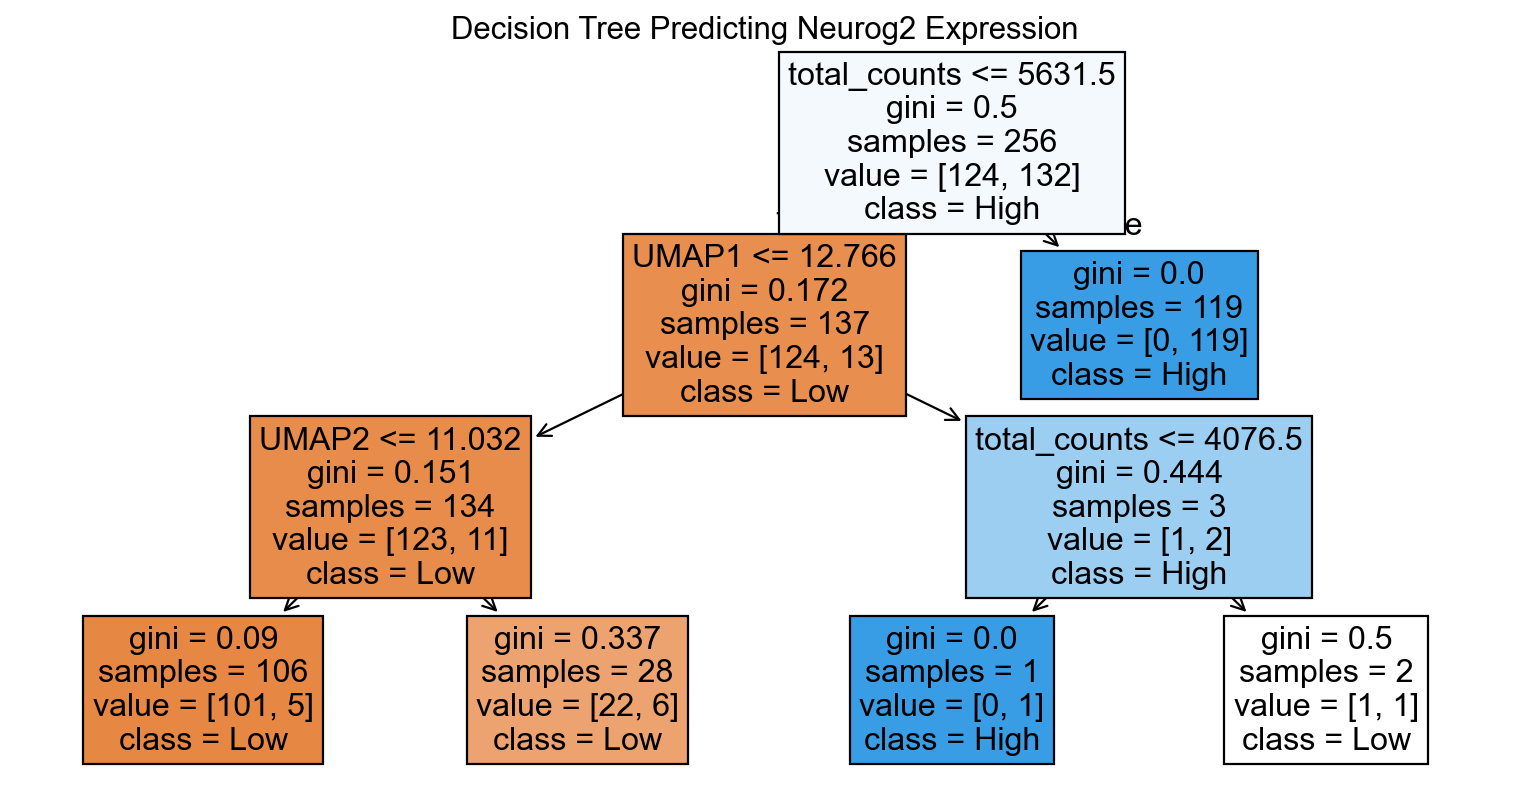

In [58]:
#53 plot tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plot_tree(clf, feature_names=x.columns, class_names=["Low", "High"], filled=True)
plt.title("Decision Tree Predicting Neurog2 Expression")
plt.show()

The decision tree models **Neurog2 expression** (classified as "High" or "Low") based on **UMAP1**, **UMAP2**, and **total_counts**. The root node first splits on **total_counts ≤ 5613.5**, separating cells with higher transcriptional activity (predictive of high Neurog2 expression). Cells with **lower total counts** are further split by **UMAP2 ≤ 13.282**, and then **UMAP1 ≤ 10.854**, forming increasingly specific subgroups. The tree correctly classifies the majority of "High" expression cells in the right branch (gini = 0, all 120 samples are "High"), while the left branch includes most "Low" expression cells. The deeper nodes in the second image show refined classification within "Low" expression cells, helping distinguish slight variability in gene expression states based on embedding coordinates. 

The decision tree reveals a link between **Neurog2** and transcriptional activity (total_counts). As well as showing the high capabilities of using UMAP to predict gene expressions patterns. The data shows that **Neurog2** could be used as a marker to distinguih an active subpopulation of cells in a dataset.




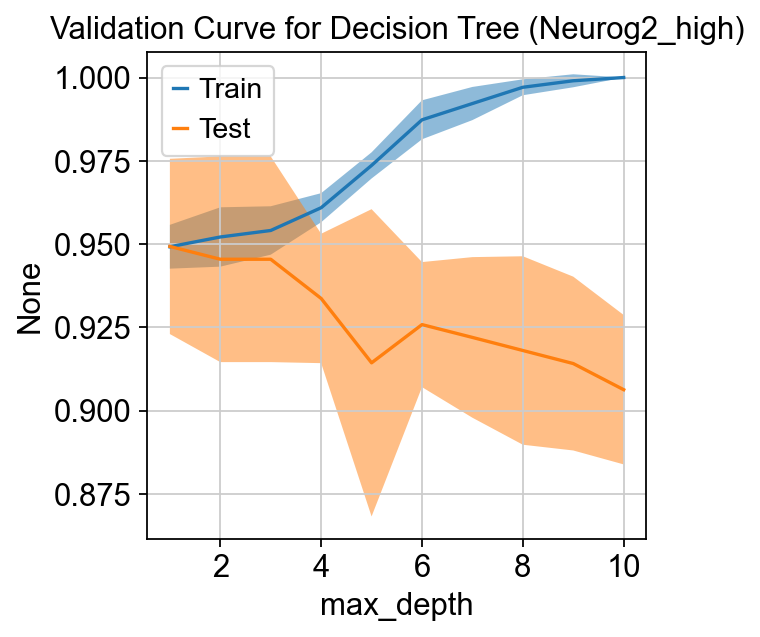

In [59]:
#54 Building a validation curve of the model
from sklearn.model_selection import ValidationCurveDisplay
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import validation_curve


# Define the parameter range you want to test
param_range = range(1, 11)

# Build validation curve
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    x_train, y_train,
    param_name="max_depth",  
    param_range=param_range,
    cv=5,
    scoring="accuracy",
)

# Plot
ValidationCurveDisplay(
    param_name="max_depth", param_range=param_range,
    train_scores=train_scores, test_scores=test_scores
).plot()
plt.title("Validation Curve for Decision Tree (Neurog2_high)")
plt.show()

The model's evaluation metrics indicate strong performance, with an 88% overall accuracy when measuring sensitivity and the False Positive Rate. However, the validation curve reveals overfitting, evidenced by the early peak between epochs 4 and 6 and the growing divergence of the training and testing curves. This overfitting may be the result from increased variance in the test data, as a result of the UMAP dimensionality reduction. To mitigate this overfitting, improving the model through leaf pruning and limiting model depth could improve an analysis of a small dataset. While the model could be used for other genes based on the performance scores, it's important to understand that performance can vary across different genes because of their varying gene expressions.

Considering both the validation curve and accuracy metrics, the model demonstrated great predictive performance for **Neurog2** expression counts.

I will be building a random tree classifier to predict cluster names based on the leiden group in adata.

**Building a Random Classifier to predict cluster names**

In [60]:
#55 Importing libraries to predict cluster names
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import scipy.sparse

In [61]:
adata.obs.head(15)

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACGGGAGCCACGTC-1     2284               2284        5717.0              0.0   
AAACGGGAGCGAGAAA-1     2105               2105        5189.0              0.0   
AAAGTAGGTACAGACG-1     2110               2110        6417.0              0.0   
AAAGTAGGTTGGACCC-1     2492               2492        7341.0              0.0   
AAATGCCCAGATTGCT-1     2021               2020        4678.0              0.0   
AACACGTCACTTCGAA-1     2495               2494        6559.0              0.0   
AACACGTTCTTACCGC-1     2222               2222        5722.0              0.0   
AACCATGCAGATGGGT-1     1789               1787        4822.0              0.0   
AACCGCGAGTCGAGTG-1     2155               2155        7167.0              0.0   
AACGTTGAGGCAATTA-1     1683               1682        4419.0              0.0   
AACGTTGAGGGCTCTC-1     1867               1867        4102.0              0.0   
AACGTTGAGTCATCCA-1     2022               2022        4500.0              0.0   
AACGTTGAGTGCAAGC-1     2019               2015        5311.0              0.0   
AACTCTTTCCAAACAC-1     1907               1906        4521.0              0.0   
AACTGGTGTCCAACTA-1     2260               2260        5884.0              0.0   

                    pct_counts_mt                   leiden  
AAACGGGAGCCACGTC-1            0.0     Intermediate Neurons  
AAACGGGAGCGAGAAA-1            0.0     Intermediate Neurons  
AAAGTAGGTACAGACG-1            0.0  Early Neurons Precursos  
AAAGTAGGTTGGACCC-1            0.0  Early Neurons Precursos  
AAATGCCCAGATTGCT-1            0.0     Intermediate Neurons  
AACACGTCACTTCGAA-1            0.0    Mesenchymal stem-like  
AACACGTTCTTACCGC-1            0.0  Early Neurons Precursos  
AACCATGCAGATGGGT-1            0.0        Neuron Maturation  
AACCGCGAGTCGAGTG-1            0.0        Neuron Maturation  
AACGTTGAGGCAATTA-1            0.0    Mesenchymal stem-like  
AACGTTGAGGGCTCTC-1            0.0             Housekeeping  
AACGTTGAGTCATCCA-1            0.0     Intermediate Neurons  
AACGTTGAGTGCAAGC-1            0.0        Neuron Maturation  
AACTCTTTCCAAACAC-1            0.0         Dividing Neurons  
AACTGGTGTCCAACTA-1            0.0        Neuron Maturation

In [62]:
print(adata.var_names)

Index(['Ncoa2', 'Eya1', 'Kcnb2', 'Gdap1', 'Mcm3', 'B3gat2', 'Adgrb3', 'Prim2',
       'Mitd1', 'Rnf149',
       ...
       'Hspa12a', 'Eno4', 'Emx2', 'E330013P04Rik', 'Cacul1', 'mt-Nd1',
       'mt-Co2', 'mt-Nd4', 'mt-Nd5', 'PISD'],
      dtype='object', length=1687)


In [63]:
#56 Creating a second list for marker genes, I will be using the top 100 genes.
marker_genes_2 = list(adata.var_names[0:100])

# Extract feature matrix using only the marker genes
X = adata.X

In [64]:
#57 Setting the y varaible for plotting using the cluster names from leiden
y = adata.obs['leiden'].values

In [65]:
#58 Splitting the data into test and train for my model
indices = np.arange(len(y))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=y)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [66]:
#59 Building the Random Classifier model, then training and testing it
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [67]:
#60 Training and predicting the classification model on the data.
predictions = np.empty_like(y, dtype=object)
predictions[train_idx] = y_train
predictions[test_idx] = clf.predict(X_test)

adata.obs['predicted_leiden'] = predictions



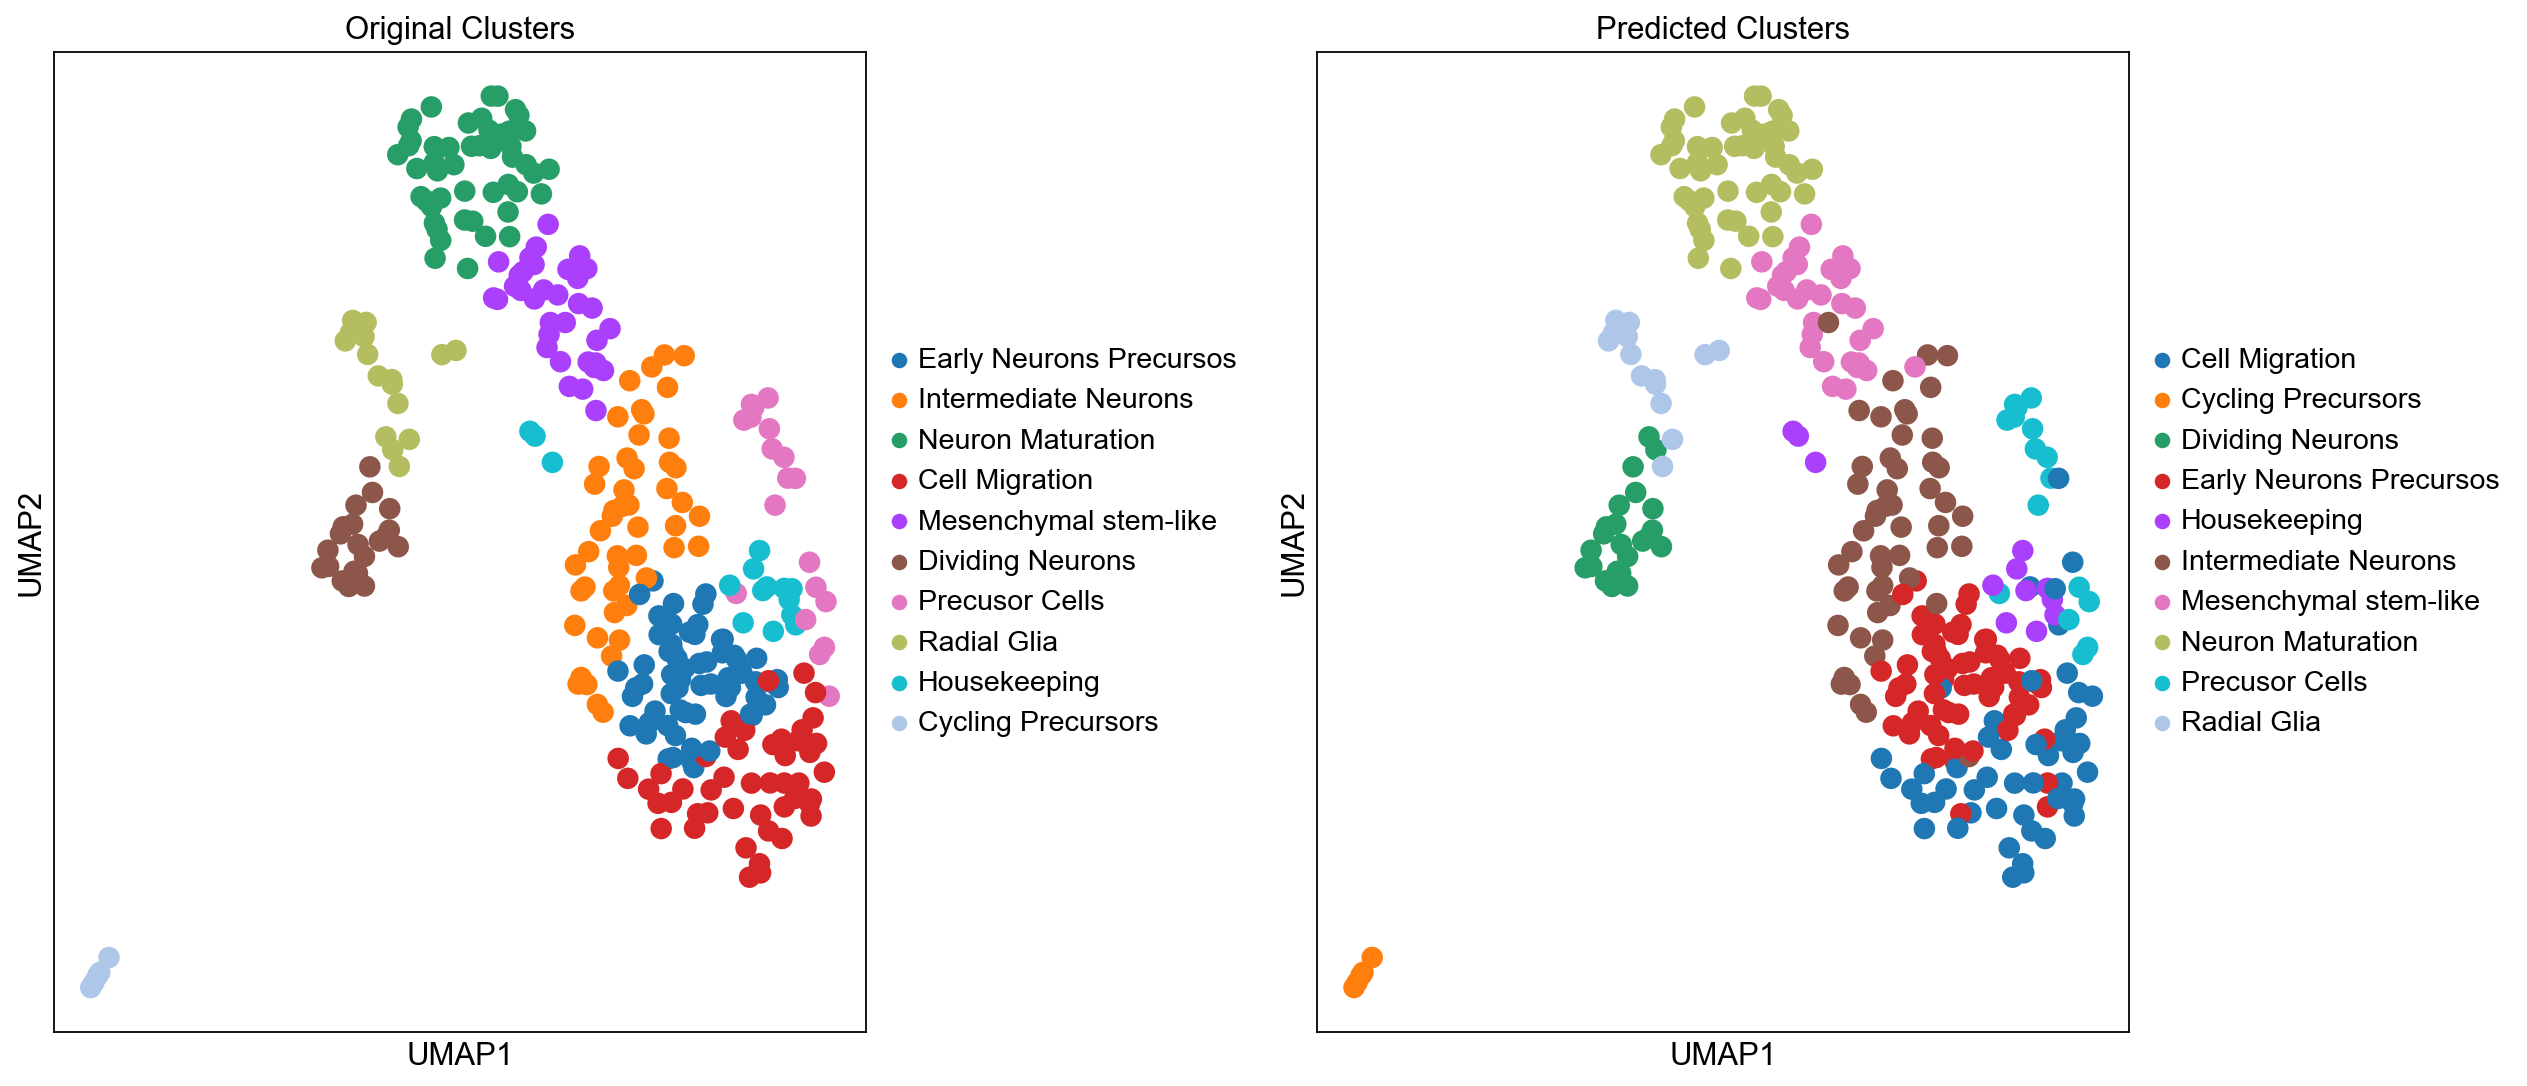

In [68]:
#61 Plotting the predictions
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Original Clusters')
sc.pl.umap(adata, color='predicted_leiden', ax=axes[1], show=False, title='Predicted Clusters')
plt.tight_layout()
plt.show()

This prediction model does not look good, lets go ahead and evaluate metrics of the model

In [69]:
#62 Identify misclassified cells
misclassified = test_idx[clf.predict(X_test) != y_test]

misclassified_cells = adata.obs_names[misclassified]
adata.obs['prediction_status'] = 'Correct'
adata.obs.loc[misclassified_cells, 'prediction_status'] = 'Misclassified'


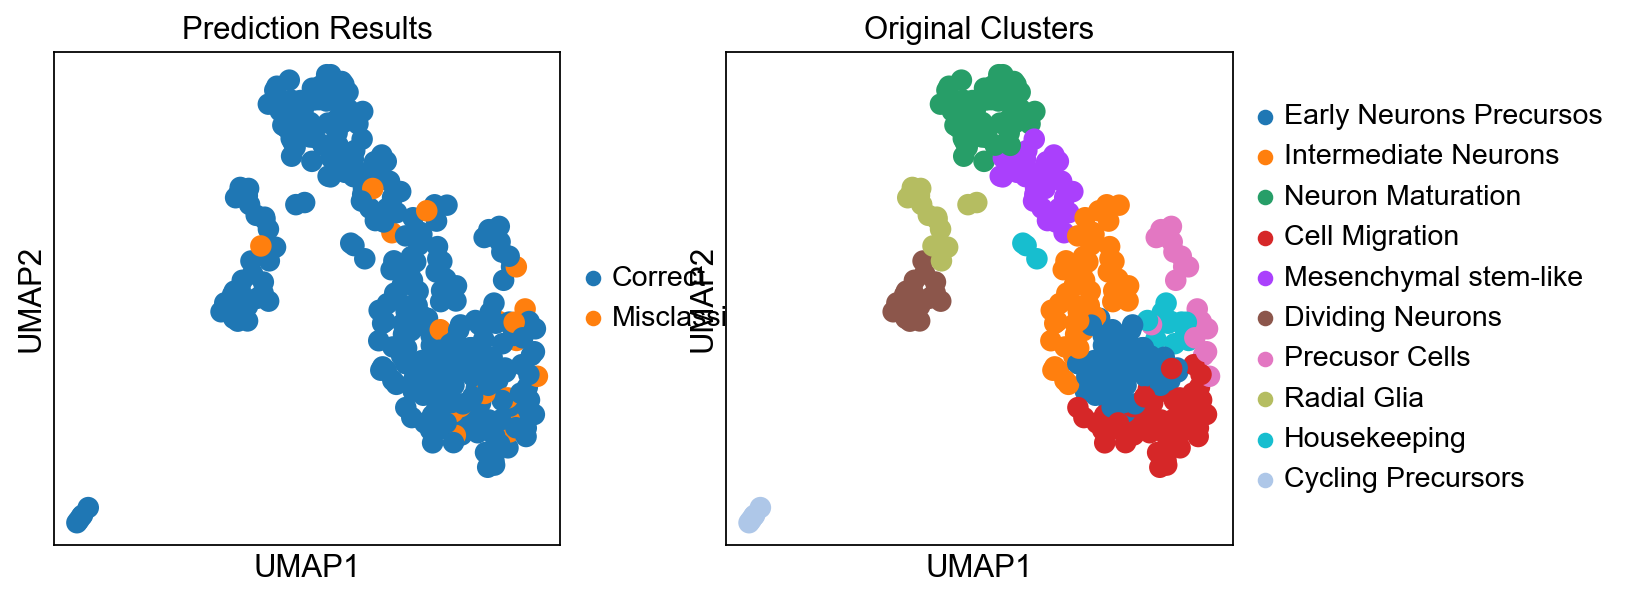

In [70]:
#63 Creating a plot to show misclassifications
sc.pl.umap(adata, color=['prediction_status', 'leiden'], 
           title=['Prediction Results', 'Original Clusters'],
           frameon=True)


Looking at the correct predictions of the model, it has performed outstandigly with a majority of predictions being correct. Observing the orange dots on the left handside, it seems that the errors are spaced out indicating random errors and a need to fine tune the model. However, there is a set of oranges at the bottom right of the cluster which could point to the model struggling to differentiate between cells within that cluster. 

In [71]:
#64 Extracting the prediction from the test data set
y_pred = clf.predict(X_test)

In [72]:
#65 Visuazling the predictions to understand the models performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
                         precision    recall  f1-score   support

         Cell Migration       0.50      0.57      0.53        14
     Cycling Precursors       1.00      1.00      1.00         1
       Dividing Neurons       0.75      1.00      0.86         6
Early Neurons Precursos       0.76      0.84      0.80        19
           Housekeeping       1.00      0.25      0.40         4
   Intermediate Neurons       0.78      0.93      0.85        15
  Mesenchymal stem-like       0.90      0.82      0.86        11
      Neuron Maturation       1.00      1.00      1.00        15
         Precusor Cells       1.00      0.50      0.67         6
            Radial Glia       1.00      0.60      0.75         5

               accuracy                           0.79        96
              macro avg       0.87      0.75      0.77        96
           weighted avg       0.82      0.79      0.78        96



The model correctly classified 79% of the samples in the test set, showing a strong performance for the model. However, looking at the indidividual classification report the model did struggle to differentiate between certain cell types. This was observed in the plot above with the localization of orange dots in the bottom left area of the grapgh. The model struggled the most with classifying Cell Migration. Looking at the cells with high precision but a low reclass, such as Housekeeping, point to the models selectivness when classfying these celss, this could be due to the large expression of housekeeping genes across all samples in the dataset.

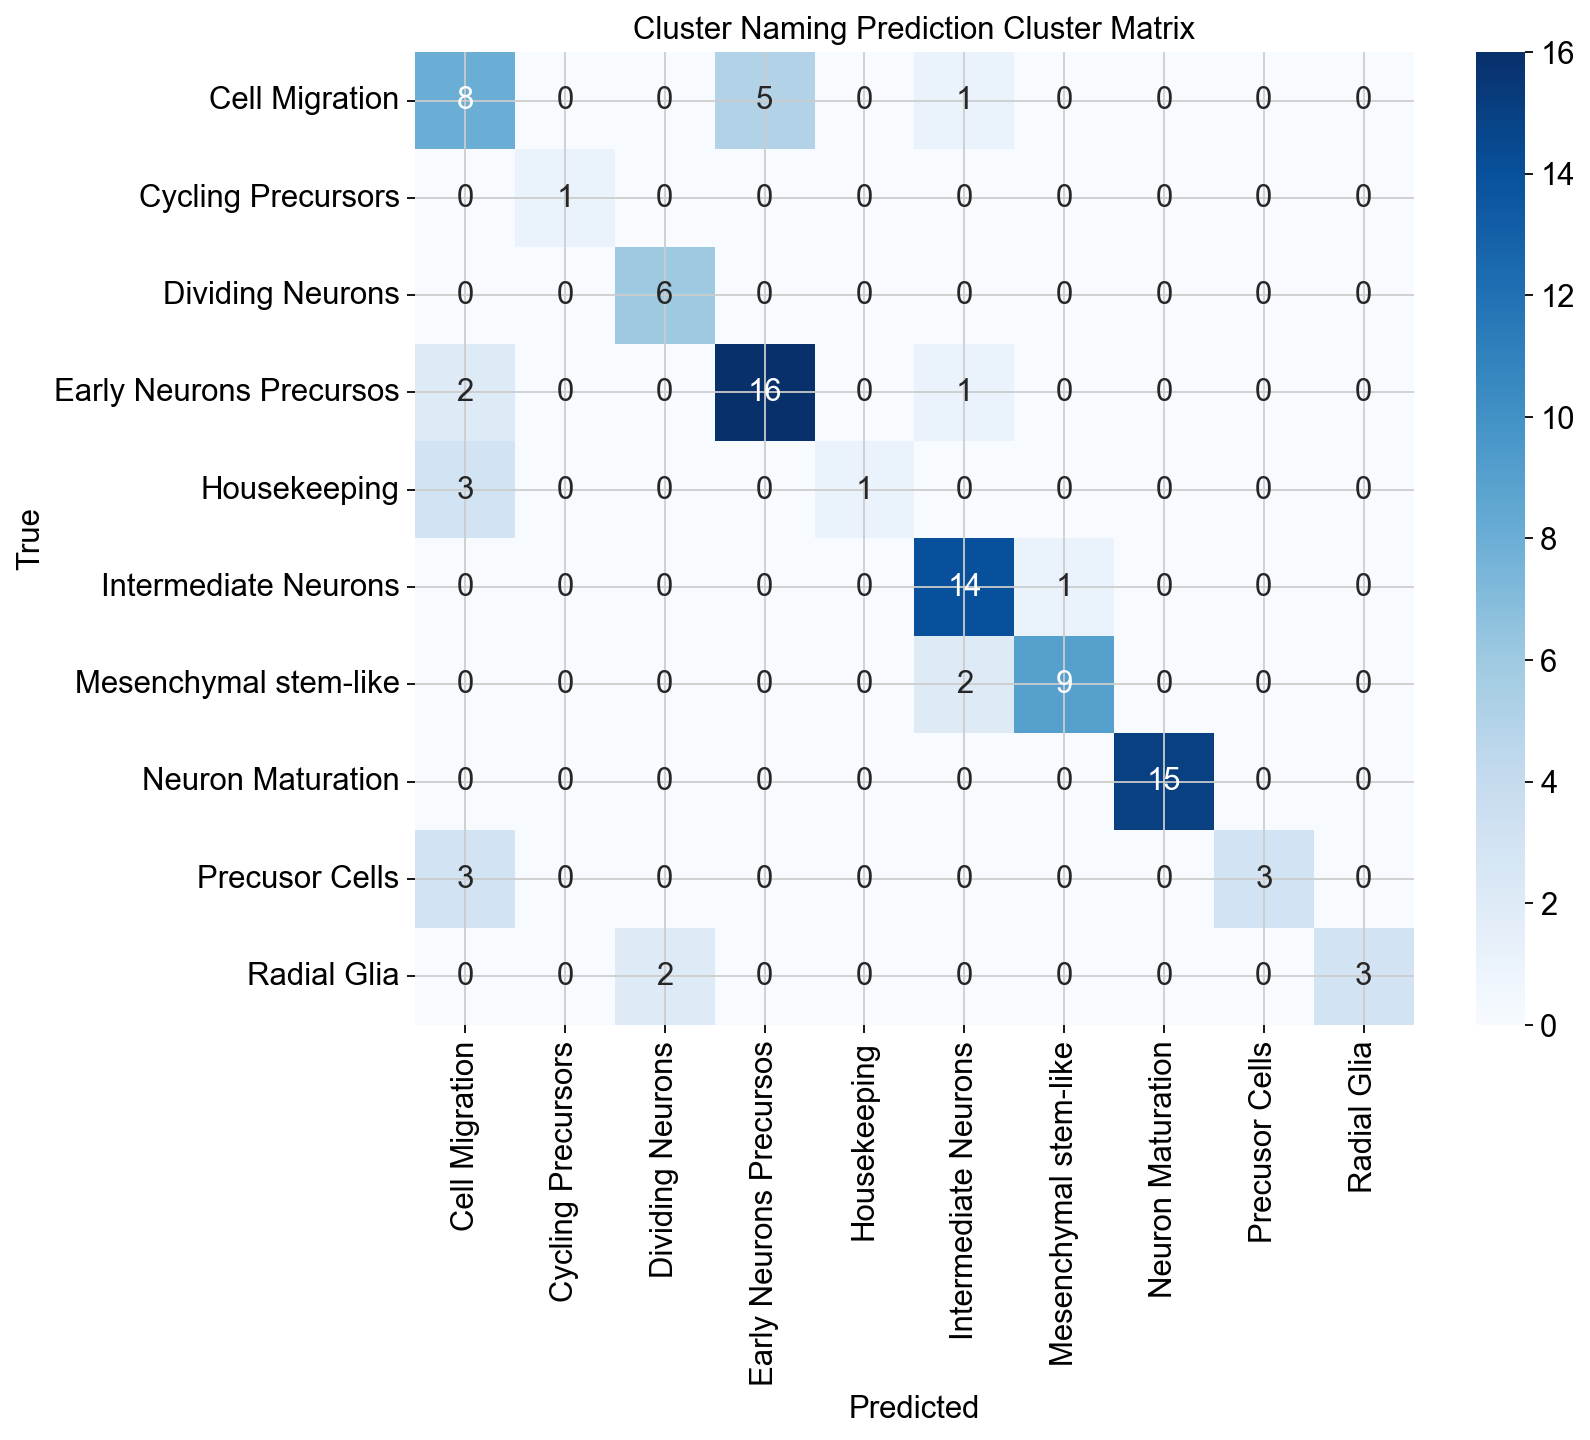

In [73]:
#66 Visualizing where the model made mistakes using a confusion matrix, higher values are better
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Cluster Naming Prediction Cluster Matrix")
plt.show()

The cluster matrix shows the predicted values from the model against the actual names for the clusters. The model had a strong performance signified by high numbers along the diagonal. With the model strongly predicting clusters related to neurons (Neuron maturation, Intermediate Nuerons, and Early Neuron Precursors). Values that are off the diagonal represent misclasification that could be due to dataset issues that inhibit model perfromance. 

**Acknowledgment**

At the beginning of this project, I was excited to learn how to use scanpy for single data analysis. I am highly interested in pursuing a PhD and one of the fields I have been considering was Bioinformatics with a focus on drug discovery and pathogenesis. This project was a wonderful introduction to bioinformatics and the possibilities that can be accomplished with data sciecne in the world of molecular biology. I have gained a lot of new insight in python, machine learning, and suprisingly mathematics (linear algebra for Machine Learning).

While working on the project, it was difficult understanding my data intially and what I could do with it. However, after watching youtube videos and reading peer reviewed articles, I understand the science behind the sequencing technology and its evolution since its release in the early years of the 21st century.A cool aspect of my project was to predict gene expression and cluster names, it was fun to work with Machine Learning and employ it in a real life biological situation.

**Referneces**

-Heumos, L., Schaar, A. C., Lance, C., Litinetskaya, A., Drost, F., Zappia, L., Lücken, M. D., Strobl, D. C., Henao, J., Curion, F., Schiller, H. B., & Theis, F. J. (2023, March 31). Best practices for single-cell analysis across modalities. Nature News. https://www.nature.com/articles/s41576-023-00586-w 

-Ilicic, T., Kim, J. K., Kolodziejczyk, A. A., Bagger, F. O., McCarthy, D. J., Marioni, J. C., & Teichmann, S. A. (2016, February 17). Classification of low quality cells from single-cell RNA-seq data - genome biology. BioMed Central. https://genomebiology.biomedcentral.com/articles/10.1186/s13059-016-0888-1 

-Nitsch, L., Lareau, C. A., & Ludwig, L. S. (2024, July). Mitochondrial genetics through the lens of single-cell multi-omics. Nature genetics. https://pmc.ncbi.nlm.nih.gov/articles/PMC11260401/ 

-Tang, F., Barbacioru, C., Wang, Y., Nordman, E., Lee, C., Xu, N., Wang, X., Bodeau, J., Tuch, B. B., Siddiqui, A., Lao, K., & Surani, M. A. (2009, April 6). MRNA-seq whole-transcriptome analysis of a single cell. Nature News. https://www.nature.com/articles/nmeth.1315 